Lab1-1-BRATS-3D-fastMONAI-extended.ipynb | A. Lundervold | v2024-01-01

# Brain tumor 3D segmentation with fastMONAI

This notebook is essentially a cell-by-cell commented copy of the **multi-class semantic segmentation** notebook `10d_tutorial_multiclass_segmentation.ipynb` from [fastMONAI](https://github.com/MMIV-ML/fastMONAI), and also incoporating parts of the extended notebook in https://github.com/MMIV-ML/fastMONAI/tree/master/presentations/MMIV-1022. We will not have time for a detailed introduction to MONAI. Please consult the documentation: https://monai.io and also see their [tutorials](https://github.com/Project-MONAI/tutorials).

| Notebook    |      1-Click Notebook      |
|:----------|------|
|  [Lab1-1-BRATS-3D-fastMONAI-extended.ipynb](https://nbviewer.jupyter.org/github/MMIV-ML/ELMED219/blob/main/Lab1-mpMRI-glioma/Lab1-1-BRATS-3D-fastMONAI-extended.ipynb)<br> The present notebook   | [![Google Colab](../assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219/blob/main/Lab1-mpMRI-glioma/Lab1-1-BRATS-3D-fastMONAI-extended.ipynb)|
|  [10d_tutorial_multiclass_segmentation.ipynb](https://nbviewer.jupyter.org/github/MMIV-ML/fastMONAI/blob/main/nbs/10d_tutorial_multiclass_segmentation.ipynb)<br> fastMONAI tutoral on multi-class semantic segmentation   | [![Google Colab](../assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/nbs/10d_tutorial_multiclass_segmentation.ipynb)|
|  [MMIV-Oct2022-brain_tumor_segmentation.ipynb](https://nbviewer.jupyter.org/github/MMIV-ML/fastMONAI/blob//blob/master/presentations/MMIV-1022/MMIV-Oct2022-brain_tumor_segmentation.ipynb)<br> fastMONAI demo (A.S.L.) at the MMIV Seminar, October 21, 2022 | [![Google Colab](../assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/presentations/MMIV-1022/MMIV-Oct2022-brain_tumor_segmentation.ipynb)|

The tutorial notebook shows how to construct a training workflow of a **multi-labels segmentation task**:<br>

_Obtain pre-defined biologically/clinically significant subregions of a brain tumor from multiparametric 3D MRI recordings using supervised learning with 3D convolutional deep neural networks_, i.e.

##  Multilabel tumor segmentation:  $y  \approx f(X; \theta)$

### Data $X$:

In our case we are using multiparametric magnetic resonance images ([mp-MRI](https://en.wikipedia.org/wiki/MRI_sequence)) recordings from previous BraTS challenges openly available in the **Medical Segmentation Decathlon** ([MSD](https://arxiv.org/abs/2106.05735)) repository (http://medicaldecathlon.com) as `Task01_BrainTumor.tar` (see also https://decathlon-10.grand-challenge.org).

The data set consists of 750 mp-MRI recordings from patients diagnosed with either glioblastoma or lower-grade glioma (LGG). The sequences used were native
T1-weighted (T1), post-Gadolinium (Gd) contrast T1-weighted (T1-Gd), native T2-weighted (T2),
and T2 Fluid-Attenuated Inversion Recovery (FLAIR). The corresponding target ROIs were the
three tumor sub-regions, namely edema, enhancing, and non-enhancing tumor. This data set was
selected due to the challenge of locating these complex and heterogeneously-located targets. The
data was acquired from 19 different institutions and contained a subset of the data used in the
[2016](https://www.smir.ch/BRATS/Start2016) and [here](https://paperswithcode.com/dataset/brats-2016) and [2017](https://www.med.upenn.edu/sbia/brats2017.html) Brain Tumor Segmentation (BraTS) challenges [12, 13, 14].

There are a total of 750 4D volumes available, 484 four-channel MRI images (`imagesTr` folder) with corresponding multi-label images (`labelsTr`) available for training, and 266 mpMRI recordings (no corresponding labels provided) in the `ìmagesTs`folder. The provided data are distributed after their pre-processing, i.e. co-registered to the same anatomical template, interpolated to the same resolution (1 mm$^3$) and skull-stripped. 


### Labels and classes $y$:

In this challenge we have the following **labels** for the data:
  - label 0 is non-tumor
  - label 1 is the peritumoral edema
  - label 2 is the necrotic and non-enhancing tumor core
  - label 3 is the GD-enhancing tumor

The possible **classes** are:
  - TC (Tumor core)
  - WT (Whole tumor)
  - ET (Enhancing tumor)

(merging label 2 and label 3 to construct TC, merging labels 1, 2 and 3 to construct WT, and label 3 is ET)

<!-- 
![img](./assets/ELMED219-Lab1-BraTS-data.png)
-->
<img src="./assets/ELMED219-Lab1-BraTS-data.png" alt="ELMED219-Lab1-BraTS-data" width=900>

### Model $f$ and trainable parameters $\theta$:

In our $y  \approx f(X; \theta)$ notation we will for each voxel location $v \in \Omega(X)$ (spatial domain of the multiparametric brain image $X$) have


- $y_v \in \{y_1, y_2, y_3, y_4\}$ = {_TC_ (= 2 $\cup$ 3), _WT_ (= 1 $\cup$ 2 $\cup$ 3), _ET_ (= 3), non-tumor (= 0)} (these regions are illustrated in the figure below)


- $f$ is a 3D convolutional deep neural net model (i.e. `SegResNet`), and 


- $\theta = (\theta_1, \theta_2, ...., \theta_p)$ is the $p$ trainable model parameters (``synaptic weights") in $f$ (in our `SegResNet` model $p \sim 4.7 \cdot 10^6$), and


- $\approx$ denotes _approximation_ expressed by a loss function or performance metric such as the Dice coefficient for the segmentation, e.g. accross one epoch during training: 


And it contains the following steps:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

<!-- 
![img](./assets/brats_tasks.png)
-->
<img src="./assets/brats_tasks.png" alt="brats_tasks" width=900>


The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).



### Note on BraTS 2021

- **[NVIDIA Data Scientists](https://developer.nvidia.com/blog/nvidia-data-scientists-take-top-spots-in-miccai-2021-brain-tumor-segmentation-challenge) Take Top Spots in MICCAI 2021 [Brain Tumor Segmentation Challenge](http://www.braintumorsegmentation.org)**:


 - Optimized U-Net for Brain Tumor Segmentation – Rank #1 (based on [`nnU-Net`](https://github.com/MIC-DKFZ/nnUNet) winner of [BraTS 2020](https://www.med.upenn.edu/cbica/brats2020) by [Isense et al.](https://arxiv.org/abs/2011.00848))
  
  
 - SegResNet: Redundancy Reduction in Semantic Segmentation of 3D Brain MRIs – Rank #2<br> The main model is the SegResNet architecture from MONAI, a standard encoder-decoder based convolutional neural network (CNN) similar to U-Net. 

<!-- 
![SegResNet](https://developer-blogs.nvidia.com/wp-content/uploads/2021/09/BRaTS-fig-2.png)
-->
<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2021/09/BRaTS-fig-2.png" alt="BRaTS-fig-2" width=900>
  
_A typical segmentation example with predicted labels overlaid overT1c MRI axial, sagittal and coronal slices. The whole tumor (WT) class includes all visible labels (a union of green, yellow and red labels), the tumor core (TC) class is a union of red and yellow, and the enhancing tumor core (ET) class is shown in yellow
(a hyperactive tumor part)._


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Brain-tumor-segmentation-using-fastMONAI" data-toc-modified-id="Brain-tumor-segmentation-using-fastMONAI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Brain tumor segmentation using <code>fastMONAI</code></a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Load-and-inspect-the-data" data-toc-modified-id="Load-and-inspect-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load and inspect the data</a></span><ul class="toc-item"><li><span><a href="#Inspect-the-data" data-toc-modified-id="Inspect-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Inspect the data</a></span></li><li><span><a href="#Data-augmentation-and-dataloaders" data-toc-modified-id="Data-augmentation-and-dataloaders-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data augmentation and dataloaders</a></span><ul class="toc-item"><li><span><a href="#What-is-data-augmentation?" data-toc-modified-id="What-is-data-augmentation?-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>What is data augmentation?</a></span></li><li><span><a href="#Create-dataloaders" data-toc-modified-id="Create-dataloaders-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Create dataloaders</a></span></li></ul></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Model-architecture" data-toc-modified-id="Model-architecture-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model architecture</a></span></li><li><span><a href="#Loss-function" data-toc-modified-id="Loss-function-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loss function</a></span></li></ul></li><li><span><a href="#Evaluate-results" data-toc-modified-id="Evaluate-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate results</a></span><ul class="toc-item"><li><span><a href="#Inference-on-test-data" data-toc-modified-id="Inference-on-test-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Inference on test data</a></span></li></ul></li><li><span><a href="#Export-the-model-and-dataloader" data-toc-modified-id="Export-the-model-and-dataloader-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Export the model and dataloader</a></span></li><li><span><a href="#Extra:-Radiomics" data-toc-modified-id="Extra:-Radiomics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Extra: Radiomics</a></span></li></ul></div>

# Brain tumor segmentation using `fastMONAI`

This notebook illustrates an approach to constructing a brain tumor segmentation model based on MR images. We aim to extract meaningful tumor regions directly from multimodal MRI (T1w, T1ce, T2w, and FLAIR). In this case, the active tumor (AT), necrotic core (NCR), and peritumoral edematous/infiltrated tissue (ED).

<img src="https://github.com/MMIV-ML/fastMONAI/raw/master/presentations/MMIV-1022/assets/brain_tumor.jpeg" width=900>

Here's an illustration of what we want to achieve (illustration taken from the BraTS Challenge):

<img src="https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg" width=900>

# Setup

We must first set up the software libraries we'll use to construct our model. Chief among these is the `fastMONAI` library.

<a href="https://fastmonai.no"><img src="https://github.com/MMIV-ML/fastMONAI/raw/master/presentations/MMIV-1022/assets/fastmonai_no.png" width=900 ></a>

### Check your platform

In [73]:
import platform
import os
from os.path import expanduser
home = expanduser("~")

if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    OVERLEAF_dir = f'{home}/Dropbox/Apps/Overleaf/My_project'
    TREE = '/usr/local/bin/tree -L 1'          # MacOS (brew install tree)
    MacOS = True
    Linux = False
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    OVERLEAF_dir = f'{home}/Dropbox/Apps/Overleaf/My_project'
    TREE = '/usr/bin/tree -L 4'
    Linux = True
    MacOS = False
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')
    MacOS = False
    Linux = False

OK, you are running on Linux (#40~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 16 10:53:04 UTC 2)


This code in the cell checks the operating system on which the code is running and sets up some variables accordingly. Here's a breakdown of the code:

- The `platform` module is imported to access information about the operating system.
- The `os` module is imported to interact with the operating system.
- The `expanduser` function from `os.path` is imported to expand the `~` symbol in file paths to the user's home directory.

The code then checks the operating system using `platform.system()` and performs different actions based on the result:

- If the operating system is identified as 'Darwin', which corresponds to macOS, the code prints a message indicating that the code is running on macOS and sets the `OVERLEAF_dir` variable to a specific path on the user's Dropbox. It also sets the `TREE` variable to the command for displaying a directory tree structure on macOS.
- If the operating system is identified as 'Linux', the code prints a message indicating that the code is running on Linux and sets the `OVERLEAF_dir` variable to a specific path on the user's Dropbox. It also sets the `TREE` variable to the command for displaying a directory tree structure on Linux.
- If the operating system is identified as 'Windows', the code prints a message suggesting the installation of Windows Subsystem for Linux (WSL) for better compatibility. It also sets the `MacOS` and `Linux` variables to `False`.

The purpose of this code is to set up specific configurations or paths based on the operating system on which the code is running. It provides different paths and commands for macOS, Linux, and Windows operating systems, allowing for platform-specific behavior or settings.

### Check if Colab and GPU is available

In [74]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()

except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")
    #%pip install fastMONAI # (8m 23 s on MacOS; 7 m 51 s on Ubuntu 20.04)
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()


Not running in Google Colab.
GPU attached.


This code snippet checks whether the notebook is running in a Google Colaboratory environment or not. Here's a breakdown of the code:

- The code starts with a `try-except` block. It attempts to import the `google.colab` module, which is specific to Google Colaboratory. If the import is successful, it means that the code is running in a Colab environment, and the `is_colab` variable is set to `True`.

- If the import fails and raises an `ImportError`, it means that the code is not running in a Colab environment, and the `is_colab` variable is set to `False`.

- Depending on whether the code is running in Colab or not, it prints a corresponding message indicating the environment.

- If the code is running in Colab, it installs the `fastMONAI` library using `%pip install fastMONAI`. The `%pip` syntax is specific to Colab and is used to install Python packages directly from the notebook.

- It then imports the `print_colab_gpu_info` function from `fastMONAI.utils` and calls it to print information about the GPU available in the Colab environment.

- If the code is not running in Colab, it skips the installation step and directly imports the `print_colab_gpu_info` function from `fastMONAI.utils`. It then calls the function to print GPU information, although this information may not be available or relevant outside of Colab.

Overall, this code snippet is checking the environment and performing environment-specific actions, such as installing packages or printing GPU information, based on whether the code is running in Google Colaboratory or not.

In [75]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

In this code excerpt, the following actions are taking place:

- The `fastMONAI.vision_all` module is being imported using the `from ... import *` syntax. This syntax imports all the functions, classes, and variables defined in the `fastMONAI.vision_all` module, making them directly accessible without needing to prefix them with the module name.

- The `monai.apps` module is being imported, specifically the `DecathlonDataset` class. This class is likely part of the MONAI library and is used for loading and working with the Decathlon dataset, which is a collection of medical imaging datasets for various tasks.

- The `sklearn.model_selection` module is being imported, specifically the `train_test_split` function. This function is part of the scikit-learn library and is commonly used for splitting datasets into training and testing subsets.

By importing these modules and classes, the code is preparing to use the functionalities provided by `fastMONAI`, `monai.apps`, and `sklearn.model_selection` in the subsequent code.

To find out what functions and classes are contained in `fastMONAI.vision_all`, you can use the `dir()` function in Python. Here's an example:



In [96]:
from fastMONAI.vision_all import *

print(dir())

['APScoreBinary', 'APScoreMulti', 'AccumMetric', 'ActivationStats', 'Adam', 'AdaptiveAvgPool', 'AdaptiveConcatPool1d', 'AdaptiveConcatPool2d', 'AddMaskCodes', 'AffineCoordTfm', 'AlexNet', 'AlexNet_Weights', 'Any', 'ArrayBase', 'ArrayImage', 'ArrayImageBW', 'ArrayImageBase', 'ArrayMask', 'AttrDict', 'AttrGetter', 'AutoInit', 'AvgLoss', 'AvgMetric', 'AvgPool', 'AvgSmoothLoss', 'BBoxBlock', 'BBoxLabeler', 'BBoxLblBlock', 'BCELossFlat', 'BCEWithLogitsLossFlat', 'BILINEAR', 'BalancedAccuracy', 'BaseLoss', 'BatchNorm', 'BatchNorm1dFlat', 'BatchSampler', 'BinaryConverter', 'BnFreeze', 'BraTSMaskConverter', 'BrierScore', 'BrierScoreMulti', 'Brightness', 'BuiltinFunctionType', 'BuiltinMethodType', 'BypassNewMeta', 'ByteTensor', 'CSVLogger', 'Callable', 'Callback', 'CancelBackwardException', 'CancelBatchException', 'CancelEpochException', 'CancelFitException', 'CancelStepException', 'CancelTrainException', 'CancelValidException', 'CastToTensor', 'Cat', 'Categorize', 'Category', 'CategoryBlock', 



By importing all the contents from `fastmonai.vision_all` using the `from ... import *` syntax and then calling `dir()`, you will get a list of all the names defined in the current scope. This will include the functions, classes, and variables imported from `fastmonai.vision_all`.

You can examine the output of `dir()` to see the names of the functions and classes available in `fastmonai.vision_all`. Note that this will also include any other names defined in your current scope, so you may need to filter the results to focus on the names specific to `fastmonai.vision_all`.

### Check our environment and computing resources

In [76]:
from monai.config import print_config
print_config()

MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/arvid/anaconda3/envs/elmed219/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 10.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

The code snippet is importing the `print_config` function from the `monai.config` module and then calling the `print_config()` function.

Here's a breakdown of what this code does:

- The `from monai.config import print_config` statement imports the `print_config` function from the `monai.config` module. The `monai.config` module is part of the MONAI library, which is a deep learning library for medical imaging.

- The `print_config()` function is then called. This function is responsible for printing the configuration settings of the MONAI library. It provides information about the current configuration, such as the version of MONAI, the PyTorch version, and other relevant settings.

By executing this code, the configuration details of the MONAI library will be printed to the output. This can be useful for verifying the library version, checking the configuration settings, and ensuring that the MONAI library is properly installed and configured in the current environment.

# Load and inspect the data

> We will use the brain tumors dataset from the Medical Segmentation Decathlon challenge (http://medicaldecathlon.com/). The data is collected from the Multimodal Brain Tumor Image Segmentation Benchmark Challenge (BraTS) dataset from 2016 and 2017. The task is to segment tumors into three different subregions (active tumor (AT), necrotic core (NCR), and peritumoral edematous/infiltrated tissue (ED)) from multimodal multisite MRI data (T1w, T1ce, T2w, and FLAIR). 

In [77]:
if is_colab:
   ! wget https://raw.githubusercontent.com/MMIV-ML/ELMED219/main/Lab1-mpMRI-glioma/assets/brats-montage.png
   image = Image.open("brats-montage.png") # Load the image.
   rotated_image = image.rotate(180) # Rotate the image by 180 degrees.
   rotated_image.save("brats-montage-rot180.png") # Save the rotated im
   !ls *.png
else:
   from PIL import Image # Import Image class from the library.
   image = Image.open("./assets/brats-montage.png") # Load the image.
   rotated_image = image.rotate(180) # Rotate the image by 180 degrees.
   rotated_image.save("./assets/brats-montage-rot180.png") # Save the rotated im

This code snippet checks whether the notebook is running in a Google Colaboratory environment or not. Here's a breakdown of the code:

- The code starts with an `if` statement that checks the value of the `is_colab` variable. If it evaluates to `True`, it means that the code is running in a Colab environment.

- Inside the `if` block, the code uses the `!` syntax to execute shell commands directly in the Colab environment. It first uses `wget` to download an image file named "brats-montage.png" from a specific URL. 

- The `Image.open()` function from the `PIL` (Python Imaging Library) module is then used to open the downloaded image file.

- The `rotate()` method is called on the `image` object to rotate the image by 180 degrees.

- The `save()` method is used to save the rotated image as "brats-montage-rot180.png".

- The `!ls *.png` command is executed to list all the PNG files in the current directory.

- If the `is_colab` variable evaluates to `False`, indicating that the code is not running in a Colab environment, the code imports the `Image` class from the `PIL` module.

- The `Image.open()` function is then used to open the image file located at "./assets/brats-montage.png".

- The `rotate()` method is called on the `image` object to rotate the image by 180 degrees.

- The `save()` method is used to save the rotated image as "./assets/brats-montage-rot180.png".

Overall, this code snippet downloads an image file, opens it, rotates it by 180 degrees, and saves the rotated image. The specific file paths and commands used depend on whether the code is running in a Colab environment or not.

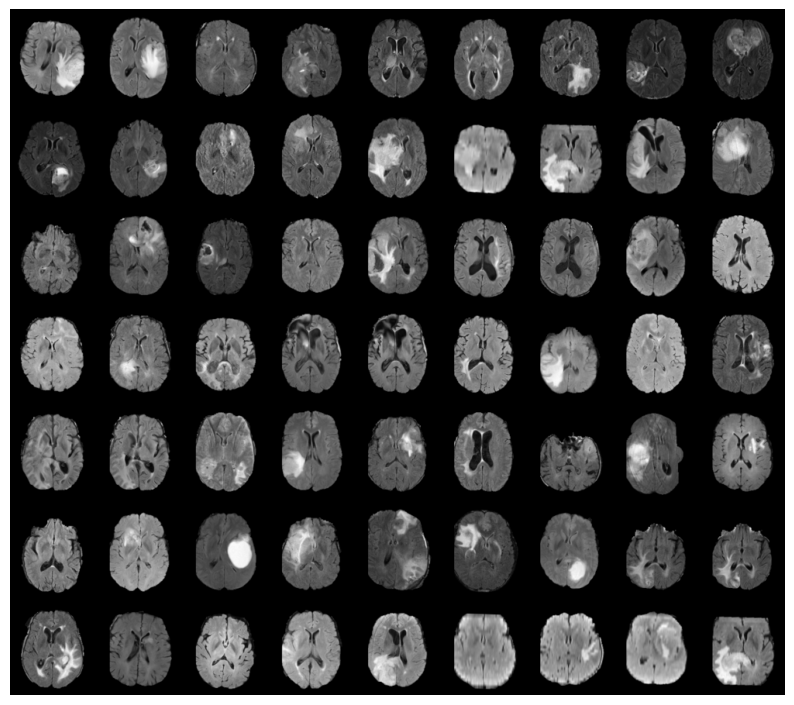

In [78]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
if is_colab:
    img = mpimg.imread('brats-montage-rot180.png')
else:
    img = mpimg.imread('./assets/brats-montage-rot180.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

# Alternatively, you can use the IPython.display.Image class to display the image directly in the notebook.
# from IPython.display import Image
# Image(filename="./assets/brats-montage-rot180.png")


This code snippet is responsible for displaying an image in the notebook using the `matplotlib` library. Here's a breakdown of the code:

- The `matplotlib.pyplot` and `matplotlib.image` modules are imported as `plt` and `mpimg`, respectively.

- The code checks the value of the `is_colab` variable. If it evaluates to `True`, indicating that the code is running in a Google Colaboratory environment, it reads the image file "brats-montage-rot180.png" using `mpimg.imread()`.

- If the `is_colab` variable evaluates to `False`, indicating that the code is not running in a Colab environment, it reads the image file "./assets/brats-montage-rot180.png" using `mpimg.imread()`.

- The `plt.figure()` function is called to create a new figure with a specified size of 10x10 inches.

- The `plt.imshow()` function is used to display the image stored in the `img` variable.

- The `plt.axis('off')` function is called to remove the axis labels and ticks from the plot.

- Finally, the `plt.show()` function is called to display the image in the notebook.

- There is also a commented-out alternative approach using the `IPython.display.Image` class to directly display the image in the notebook. This approach is not used in the current code.

Overall, this code snippet reads an image file, displays it using `matplotlib.pyplot`, and shows the image in the notebook. The specific file paths and commands used depend on whether the code is running in a Colab environment or not.

We use the MONAI function `DecathlonDataset` to download the data and generate items for training.
<!--
<img src="./assets/brats-montage-rot180.png">
-->

In [79]:
from pathlib import Path

path = Path('./data')
path.mkdir(exist_ok=True)

In the first line, the `pathlib` module is imported, which provides a convenient way to work with file paths and directories.

In the second line, a `Path` object is created with the path `./data`. The `Path` class represents a file or directory path and provides various methods for working with paths.

In the third line, the `mkdir()` method is called on the `path` object. This method creates a new directory at the specified path. The `exist_ok=True` parameter ensures that the directory is created only if it doesn't already exist. If the directory already exists, it will not raise an error.

By executing this code, a directory named "data" will be created in the current working directory if it doesn't already exist. This directory can be used to store data or files related to the code or project.

Grab the data (if not already fetched)
7.09 G [Colab: 03:20, 38.2 MB/s] [./data/Task01_BrainTumour.tar]

In [80]:
training_data = DecathlonDataset(root_dir=path, task="Task01_BrainTumour", section="training", download=True,
                                 cache_num=0, num_workers=8)

2023-12-31 14:00:04,251 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-12-31 14:00:04,251 - INFO - File exists: data/Task01_BrainTumour.tar, skipped downloading.
2023-12-31 14:00:04,252 - INFO - Non-empty folder exists in data/Task01_BrainTumour, skipped extracting.


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


The code initializes a `DecathlonDataset` object named `training_data` with various parameters:

- `root_dir=path`: This parameter specifies the root directory where the dataset is located. The value of `path` is a file path pointing to the dataset directory.

- `task="Task01_BrainTumour"`: This parameter specifies the specific task or dataset within the Decathlon dataset. In this case, it is the "Task01_BrainTumour" task, which likely corresponds to brain tumor segmentation.

- `section="training"`: This parameter specifies the section or subset of the dataset to be loaded. In this case, it is the training section, indicating that the training data will be loaded.

- `download=True`: This parameter indicates whether the dataset should be downloaded if it is not already available. Setting it to `True` will trigger the download process if necessary.

- `cache_num=0`: This parameter specifies the cache number to be used. The value `0` suggests that no caching is performed.

- `num_workers=8`: A worker process refers to an independent process that performs a specific task or job in parallel with other processes. In the context of data loading, a worker process is responsible for loading and preprocessing data independently from other worker processes. When loading large datasets or performing computationally intensive tasks, using multiple worker processes can help distribute the workload and speed up the overall process. Each worker process operates independently and can handle a portion of the data loading task concurrently. In this case, the `num_workers` parameter specifies the number of worker processes to be used for loading the data. By setting it to `8`, it indicates that eight worker processes will be utilized to load the data in parallel. This parallelization can lead to faster data loading and preprocessing, especially when dealing with large datasets.

By executing this code, a `DecathlonDataset` object named `training_data` will be created, representing the training data for the brain tumor segmentation task. The dataset will be loaded from the specified root directory, and if necessary, it will be downloaded. The data loading process will utilize eight worker processes for efficient parallel loading.

In [81]:
df = pd.DataFrame(training_data.data)

The code snippet creates a pandas DataFrame named `df` by passing the `training_data.data` attribute as the data argument.

Here's a breakdown of the code:

- `training_data` is an object representing a dataset, loaded from the `DecathlonDataset` class mentioned earlier.
- `training_data.data` refers to the data portion of the loaded dataset, which contain features, labels, or other relevant information.

By calling `pd.DataFrame()` with `training_data.data` as the argument, the code converts the data into a pandas DataFrame. A DataFrame is a two-dimensional tabular data structure provided by the pandas library, commonly used for data manipulation and analysis.

The resulting DataFrame, `df`, will have the data from `training_data.data` organized in rows and columns. Each row represents an individual data point, and each column represents a specific attribute or feature of the data.

This code allows for further analysis, exploration, or manipulation of the dataset using the rich functionality provided by pandas for working with tabular data.

We now have a bunch of **images** and **corresponding labels**. Here are the first ten images and their labels:

In [82]:
df.head(10)

,image,label
0,data/Task01_BrainTumour/imagesTr/BRATS_442.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_442.nii.gz
1,data/Task01_BrainTumour/imagesTr/BRATS_389.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_389.nii.gz
2,data/Task01_BrainTumour/imagesTr/BRATS_380.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_380.nii.gz
3,data/Task01_BrainTumour/imagesTr/BRATS_245.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_245.nii.gz
4,data/Task01_BrainTumour/imagesTr/BRATS_453.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_453.nii.gz
5,data/Task01_BrainTumour/imagesTr/BRATS_252.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_252.nii.gz
6,data/Task01_BrainTumour/imagesTr/BRATS_078.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_078.nii.gz
7,data/Task01_BrainTumour/imagesTr/BRATS_427.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_427.nii.gz
8,data/Task01_BrainTumour/imagesTr/BRATS_421.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_421.nii.gz
9,data/Task01_BrainTumour/imagesTr/BRATS_440.nii.gz,data/Task01_BrainTumour/labelsTr/BRATS_440.nii.gz


In [83]:
df.shape

(388, 2)

The code `df.shape` is used to retrieve the shape of the DataFrame `df`. 

Here's a breakdown of the code:

- `df` refers to a pandas DataFrame object that has been previously defined or loaded with data.
- The `.shape` attribute of a DataFrame returns a tuple representing the dimensions of the DataFrame. The tuple contains two values: the number of rows (=388 _instances_, or _data points_, or _records_) and the number of columns (=2 _attributes_, or _features_ -> image and label) in the DataFrame.

By executing `df.shape`, the code will return the shape of the DataFrame `df` as a tuple. This can be useful for understanding the size and structure of the DataFrame, such as the number of data points or records and the number of attributes or features present in the DataFrame.

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   388 non-null    object
 1   label   388 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


The code `df.info()` is used to display a summary of the DataFrame `df` including information about the column names, data types, and the number of non-null values in each column.

Here's a breakdown of the code:

- `df` refers to a pandas DataFrame object that has been previously defined or loaded with data.
- The `.info()` method of a DataFrame provides a concise summary of the DataFrame's structure and content.

By executing `df.info()`, the code will display information about the DataFrame `df`. This includes the total number of rows, the number of columns, the column names, the data types of each column, and the number of non-null values in each column. This summary can be helpful for understanding the data types and missing values in the DataFrame, as well as getting an overview of the data present in each column.

#### Each of the 388 data sets consists of four 3D volumes (T1, T1c, T2, FLAIR) and corresponding manual labels. Here's one example:<br><br>


| <img src="./assets/img_182_axial.gif"> | <img src="./assets/img_182_coronal.gif"> | <img src="./assets/img_182_sagittal.gif"> |
|----------|----------|----------|
| Axial         |   Coronal        |    Sagittal       |


#### Train - test split

We will train our model on parts of the data set, the so-called **training data**. After training, we'll need some new data to test our model's ability to generalize to unseen data, so-called **test data**. 

This is achieved by splitting the labeled data into two sets: training and test.

In [87]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((349, 2), (39, 2))

The code in this cell is splitting a pandas DataFrame `df` into two subsets: a training set (`train_df`) and a test set (`test_df`). Here's a breakdown of the code:

- `train_test_split` is a function from the `sklearn.model_selection` module, which is commonly used for splitting datasets into training and testing subsets.
- `df` refers to a pandas DataFrame object that has been previously defined or loaded with data.
- `test_size=0.1` specifies that the test set should contain 10% of the data, while the remaining 90% will be allocated to the training set.
- `random_state=42` sets the random seed to 42, ensuring reproducibility of the split. This means that the same split will be obtained if the code is run again with the same random seed.
- The result of the `train_test_split` function is assigned to two variables: `train_df` and `test_df`. `train_df` will contain the training set, and `test_df` will contain the test set.
- Finally, the code prints the shapes of the `train_df` and `test_df` DataFrames using the `.shape` attribute. This will display the number of rows and columns in each DataFrame.

By executing this code, the original DataFrame `df` will be split into two subsets: `train_df` for training data and `test_df` for testing data. The training set will contain 90% of the data, and the test set will contain 10% of the data. The shapes of the resulting DataFrames will be printed to provide information about the number of rows and columns in each subset.

In [90]:
list(train_df.columns), list(test_df.columns)

(['image', 'label'], ['image', 'label'])

The code in this cell is accessing the `columns` attribute of the `train_df` and `test_df` DataFrames and converting them into lists using the `list()` function. 

Here's a breakdown of the code:

- `train_df` and `test_df` are assumed to be pandas DataFrame objects that have been previously defined or loaded with data.

- The `.columns` attribute of a DataFrame returns the column labels or names of the DataFrame.

- By calling `list(train_df.columns)` and `list(test_df.columns)`, the code converts the column labels of both DataFrames into lists.

- The resulting lists will contain the column names of the `train_df` and `test_df` DataFrames, respectively.

By executing this code, the column names of the `train_df` and `test_df` DataFrames will be displayed as lists. This can be useful for inspecting and comparing the column names between the two DataFrames.

## Inspect the data

`fastMONAI` has a useful function to construct a dataset from a list of labeled images:

In [98]:
#help(MedDataset)

```python
Help on class MedDataset in module fastMONAI.dataset_info:

class MedDataset(builtins.object)
 |  MedDataset(path=None, postfix: str = '', img_list: list = None, reorder: bool = False, dtype: (<class 'fastMONAI.vision_core.MedImage'>, <class 'fastMONAI.vision_core.MedMask'>) = <class 'fastMONAI.vision_core.MedImage'>, max_workers: int = 1)
 |  
 |  A class to extract and present information about the dataset.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, path=None, postfix: str = '', img_list: list = None, reorder: bool = False, dtype: (<class 'fastMONAI.vision_core.MedImage'>, <class 'fastMONAI.vision_core.MedMask'>) = <class 'fastMONAI.vision_core.MedImage'>, max_workers: int = 1)
 |      Constructs MedDataset object.
 |      
 |      Args:
 |          path (str, optional): Path to the image folder.
 |          postfix (str, optional): Specify the file type if there are different files in the folder.
 |          img_list (List[str], optional): Alternatively, pass in a list with image paths.
 |          reorder (bool, optional): Whether to reorder the data to be closest to canonical (RAS+) orientation.
 |          dtype (Union[MedImage, MedMask], optional): Load data as datatype. Default is MedImage.
 |          max_workers (int, optional): The number of worker threads. Default is 1.
 |  
 |  get_largest_img_size(self, resample: list = None) -> list
 |      Get the largest image size in the dataset.
 |  
 |  suggestion(self)
 |      Voxel value that appears most often in dim_0, dim_1 and dim_2, and whether the data should be reoriented.
 |  
 |  summary(self)
 |      Summary DataFrame of the dataset with example path for similar data.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object
 ```
 


The code in this cell is using the `help()` function to display the documentation or help information for the `MedDataset` class.

Here's a breakdown of the code:

- `MedDataset` is assumed to be a class or object defined in the active `.ipynb` file

- By calling `help(MedDataset)`, the code displays the documentation or help information for the `MedDataset` class. This information typically includes a description of the class, its methods, attributes, and any other relevant details.

By executing this code, the help information for the `MedDataset` class will be displayed in the output. This can be useful for understanding the purpose, usage, and available functionalities of the `MedDataset` class in the context of the code or project.

In [19]:
!nproc  # !grep -c processor /proc/cpuinfo  or more extensive information:  !lscpu

16


The code in this cell is using shell commands to retrieve information about the number of processors or CPU cores available in the system.

Here's a breakdown of the code:

- `!nproc` is a shell command that is executed using the `!` syntax in Jupyter Notebook. It retrieves the number of processors or CPU cores available in the system.

- The `#` symbol indicates a comment in Python, so the rest of the line after `#` is not executed as code.

- The commented command `!grep -c processor /proc/cpuinfo` is an alternative shell command that can be used to obtain the same information. It uses the `grep` command to search for the string "processor" in the `/proc/cpuinfo` file and counts the occurrences of that string.

- The commented command `!lscpu` is another alternative shell command that provides more extensive information about the CPU, including details such as architecture, cache sizes, and more.

By executing this code, the output will display the number of processors or CPU cores available in the system. The specific command used (`nproc`, `grep`, or `lscpu`) depends on which line is uncommented.

In [94]:
%%time
#med_dataset = MedDataset(img_list=train_df.label.tolist()[:20], dtype=MedMask, max_workers=12)
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=14)

CPU times: user 1min 47s, sys: 7.94 s, total: 1min 55s
Wall time: 1min 39s


In the first line, `%%time` is a Jupyter Notebook magic command that measures and displays the execution time of the entire cell. It provides information about the time taken to run the code in the cell.

In the second line, a `MedDataset` object named `med_dataset` is being created. The `MedDataset` class is imported from a module (`fastMONAI.vision_all`) and is defined in the active `.ipynb` file.

The `MedDataset` object is initialized with the following parameters:
- `img_list=train_df.label.tolist()`: This parameter specifies the list of image labels to be used for creating the dataset. It retrieves the `label` column from the `train_df` DataFrame and converts it into a list using the `tolist()` method.
- `dtype=MedMask`: This parameter specifies the data type of the dataset. It is set to `MedMask`, which suggests that the dataset contains medical mask data.
- `max_workers=14`: This parameter specifies the maximum number of worker processes to be used for data loading. It is set to `14`, indicating that up to 14 worker processes can be utilized for efficient parallel loading.

By executing this code, a `MedDataset` object named `med_dataset` will be created, representing a dataset of medical mask data. The dataset will be initialized with the image labels from the `train_df` DataFrame, and up to 14 worker processes can be used for parallel data loading. The execution time of the cell will also be displayed.

#### **YOUR TURN:**

Test the effect of (i.e. Wall time) selecting different number of `max_workers` (e.g. 1, 4, 14) vs. Wall time.<br>
> What is your worst?  (=1 : 1min 37s)    What is your best? (=14 : 1 min 39s).

**Wall time**, also known as real time or elapsed time, refers to the total time taken to complete a task from start to finish, including all the time spent on processing, waiting, and any other activities. It represents the actual time that has passed in the real world, regardless of the activities performed during that time. Wall time is often used to measure the performance or execution time of a program or process. It is typically measured using a clock or timer and is expressed in units such as seconds, milliseconds, or microseconds.

`MedDataset` provides useful information about our data set:

In [99]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1,voxel_count_2,voxel_count_3
0,data/Task01_BrainTumour/labelsTr/BRATS_477.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8765377,83088,15826,63709.0
1,data/Task01_BrainTumour/labelsTr/BRATS_350.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8872636,21364,8872,25128.0
2,data/Task01_BrainTumour/labelsTr/BRATS_266.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8725071,83276,69784,49869.0
3,data/Task01_BrainTumour/labelsTr/BRATS_294.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8790699,90806,20231,26264.0
4,data/Task01_BrainTumour/labelsTr/BRATS_466.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8911252,14046,60,2642.0


The code in this cell is accessing the `df` attribute of the `med_dataset` object and calling the `head()` method on it.

Here's a breakdown of the code:

- `med_dataset` is assumed to be an object of the `MedDataset` class defined in the active file `.ipynb`. It represents a dataset of medical images.

- The `.df` attribute is accessed on the `med_dataset` object. This attribute likely refers to a pandas DataFrame associated with the dataset.

- The `head()` method is called on the `df` attribute. This method is used to retrieve the first few rows of the DataFrame. By default, it returns the first five rows.

By executing this code, the first few rows of the DataFrame associated with the `med_dataset` object will be displayed. This can be useful for inspecting the structure and content of the dataset, providing a glimpse of the data stored in the DataFrame.

In [100]:
summary_df = med_dataset.summary()

The code in this cell is calling the `summary()` method on the `med_dataset` object and assigning the result to a variable named `summary_df`.

Here's a breakdown of the code:

- `med_dataset` is assumed to be an object of the `MedDataset` class defined in the active file `.ipynb`. It represents a dataset of medical images.

- The `.summary()` method is called on the `med_dataset` object. This method likely provides a summary or overview of the dataset, including information such as the number of samples, class distribution, or other relevant statistics.

- The result of the `summary()` method is assigned to the variable `summary_df`. The name suggests that the result is stored in a pandas DataFrame, but the specific structure and content of the DataFrame depend on the implementation of the `summary()` method.

By executing this code, the `summary()` method is called on the `med_dataset` object, and the resulting summary information is stored in the `summary_df` variable. This summary can be used to gain insights into the dataset and understand its characteristics before further analysis or modeling.

In [101]:
summary_df

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,240,240,155,1.0,1.0,1.0,RAS+,data/Task01_BrainTumour/labelsTr/BRATS_002.nii.gz,349


We observe that in this case the voxel spacing is the same for all 349 images, and also that they are oriented identically.

Voxel value that appears most often in dim_0, dim_1 and dim_2, and wheter the data should be reoriented:

In [102]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In the given code excerpt, the `suggestion()` method is called on the `med_dataset` object, and the returned values are assigned to the variables `resample` and `reorder`. Here's a breakdown of the code:

- `med_dataset` is assumed to be an object of the `MedDataset` class defined in the active file `.ipynb`. It represents a dataset of medical images.

- The `.suggestion()` method is called on the `med_dataset` object. This method likely provides suggestions or recommendations related to resampling and reordering of the dataset.

- The returned values from the `suggestion()` method are assigned to the variables `resample` and `reorder`.

By executing this code, the `suggestion()` method is called on the `med_dataset` object, and the resulting suggestions or recommendations are stored in the `resample` and `reorder` variables. The specific values and their meanings depend on the implementation of the `suggestion()` method in the `MedDataset` class.

Get the largest image size in the dataset and resample

In [104]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[240.0, 240.0, 155.0]

In the given code excerpt, the `get_largest_img_size()` method is called on the `med_dataset` object with the `resample` parameter passed as an argument. The returned value is assigned to the variable `img_size`. Here's a breakdown of the code:

- `med_dataset` is assumed to be an object of the `MedDataset` class defined in the active file `.ipynb`. It represents a dataset of medical images.

- The `.get_largest_img_size()` method is called on the `med_dataset` object. This method likely calculates and returns the size of the largest image in the dataset.

- The `resample` parameter is passed to the `get_largest_img_size()` method. The specific value of `resample` is not provided in the given code excerpt, but it is likely a parameter that controls the resampling of the images during size calculation.

- The returned value from the `get_largest_img_size()` method is assigned to the variable `img_size`.

By executing this code, the `get_largest_img_size()` method is called on the `med_dataset` object, and the size of the largest image in the dataset is calculated. The resulting size is stored in the `img_size` variable.

## Data augmentation and dataloaders

### What is data augmentation?

**Data augmentation** is a technique used in machine learning and deep learning to artificially increase the size and diversity of a dataset by applying various transformations to the existing data. In the context of MONAI (Medical Open Network for AI), data augmentation is particularly useful for medical imaging tasks. For medical images, these transformations can be rotations, flips, zooming, pixel intensity modifications, and much more. This also ensures a degree of **invariance** to these transformations for the resulting trained models.

Why use data augmentation in MONAI?
1. Increased dataset size: Data augmentation allows you to generate additional training samples, which can help mitigate the problem of limited labeled data in medical imaging tasks. With more diverse samples, the model can learn better representations and generalize well to unseen data.
2. Improved model generalization: By applying random transformations to the data, data augmentation helps the model learn to be invariant to certain variations, such as rotation, scaling, or noise. This improves the model's ability to generalize and perform well on unseen data.
3. Robustness to variations: Medical images can exhibit variations in terms of orientation, scale, intensity, and other factors. Data augmentation helps the model become robust to these variations, making it more reliable in real-world scenarios.

How to perform data augmentation in MONAI?
MONAI provides a wide range of built-in data augmentation techniques that can be easily applied to medical imaging data. These techniques include:
- Random rotation, flipping, and scaling: These transformations help the model learn to handle different orientations and spatial variations in the data.
- Random cropping and padding: These operations allow the model to learn from different regions of the image and handle variations in image size.
- Intensity transformations: MONAI provides functions for adjusting image intensity, such as random brightness, contrast, and gamma adjustments.
- Gaussian noise and blur: These operations introduce noise or blur to the images, helping the model learn to be robust to such variations.

To apply data augmentation in MONAI, you can use the `Compose` class to create a sequence of augmentation transforms. Then, you can apply this sequence to your dataset during training or inference to generate augmented samples.

In general, there are many other possible data augmentation techniques, ranging from basic to more advanced transformations, including methods for combining multiple images into sets of "new" images (e.g., what's called "CutMix" or "MixUp" and more). Not all of these are realistic in a medical imaging setting and not available in MONAI, but many are.

Overall, data augmentation in MONAI helps improve model performance, generalization, and robustness by artificially expanding the dataset and introducing variations that mimic real-world scenarios.

Here are some illustrations of various data augmentation strategies (taken from https://www.quantib.com/blog/image-augmentation-how-to-overcome-small-radiology-datasets): 

<img src="https://www.quantib.com/hs-fs/hubfs/Blog%20and%20news%20images/Examples%20of%20rigid%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png?width=1549&name=Examples%20of%20rigid%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png">

<img src="https://www.quantib.com/hs-fs/hubfs/assets/images/blog/Examples%20of%20stretch%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png?width=3098&name=Examples%20of%20stretch%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png">

<img src="https://www.quantib.com/hs-fs/hubfs/Blog%20and%20news%20images/Examples%20of%20elastic%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png?width=1448&name=Examples%20of%20elastic%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png">

<img src="https://www.quantib.com/hs-fs/hubfs/Blog%20and%20news%20images/Contrast%20shift%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib-1.png?width=1072&name=Contrast%20shift%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib-1.png">

When doing data augmentation, it is vital that

(i) the transformations won't change the correct label (f.ex., zooming in on a region of the image that doesn't contain the information needed to assign the class of the original image. Think zooming in on a part of a bone X-ray that doesn't include the finding of interest, say, a fracture)<br><br>
(ii) be at least somewhat realistic (f.ex., if you expect all the images to have a fixed up-down orientation, as is typically the case in, say, head MRI, vertical flips will not be a good idea).


#### In our case, we normalize the image, resize them all to the same size, and do some random motion as our data augmentation:

In [108]:
size=[224,224,128]

The code snippet `size=[224,224,128]` in the given cell is assigning a list of three values to the variable `size`.

Here's a breakdown of the code:

- `size` is a variable that is being assigned a list of three values: `[224, 224, 128]`.
- The values in the list represent the desired size or dimensions of an image or volume in a 3D space. The first value `224` corresponds to the width dimension, the second value `224` corresponds to the height dimension, and the third value `128` corresponds to the depth or number of slices in the volume.
- The specific purpose or usage of this `size` variable depends on the context of the code. It could be used as a target size for resizing images or volumes, specifying the input size for a neural network model, or for any other purpose related to handling 3D image data.

By executing this code, the variable `size` will be assigned the list `[224, 224, 128]`, representing the desired dimensions or size of an image or volume in a 3D space.

In [109]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5, isotropic=True)] 

The code snippet you provided is assigning a list of transformation objects to the variable `item_tfms`.

Here's a breakdown of the code:

- `item_tfms` is a variable that is being assigned a list of transformation objects.
- The transformations in the list are:
  - `ZNormalization()`: This transformation performs z-score normalization on the input data. It subtracts the mean and divides by the standard deviation along each channel or feature dimension.
  - `PadOrCrop(size)`: This transformation pads or crops the input data to a specified size. The `size` parameter likely refers to the desired size of the data, which could be a single value for a square shape or a list of values for different dimensions.
  - `RandomAffine(scales=0, degrees=5, isotropic=True)`: This transformation applies random affine transformations to the input data. The `scales` parameter is set to `0`, indicating that no scaling will be applied. The `degrees` parameter is set to `5`, specifying the maximum rotation angle in degrees. The `isotropic` parameter is set to `True`, indicating that the scaling factors for the affine transformation will be isotropic (equal in all dimensions).

By executing this code, the variable `item_tfms` will be assigned a list of transformation objects. These transformations can be applied to the input data, such as medical images, to perform z-score normalization, padding or cropping to a specified size, and random affine transformations. The specific usage and application of these transformations depend on the context of the code and the data being processed.

After creating dataloaders that apply these transformations, we can have a look at the results.

### Create dataloaders

In MONAI, **DataLoaders** are a key component for efficiently loading and processing data during the training or inference phase of a machine learning model. DataLoaders provide an interface to handle the loading, preprocessing, and batching of data in a convenient and optimized manner.

The concept of DataLoaders in MONAI is inspired by PyTorch's DataLoader class. DataLoaders in MONAI are responsible for:
- Loading data: DataLoaders can load data from various sources, such as files, directories, or in-memory arrays. They handle the process of reading and loading the data into memory.
- Preprocessing: DataLoaders can apply a series of transformations or preprocessing steps to the loaded data. These transformations can include resizing, normalization, augmentation, or any other necessary preprocessing steps.
- Batching: DataLoaders group the preprocessed data into batches. Batching is important for efficient training or inference, as it allows processing multiple samples in parallel, leveraging the computational power of GPUs.
- Shuffling and Sampling: DataLoaders can shuffle the data within each epoch to introduce randomness and prevent the model from overfitting to the order of the data. They can also perform sampling techniques such as stratified sampling or weighted sampling to handle class imbalances or other specific requirements.
- Parallelism: DataLoaders can utilize multi-threading or multi-processing to load and preprocess data in parallel, further improving the efficiency of data loading.

By using DataLoaders in MONAI, you can streamline the data loading and preprocessing pipeline, making it easier to handle large datasets, apply transformations, and efficiently feed the data to your machine learning models during training or inference.

There are several ways to get the data in `DataLoaders`. Here we rebuild using `DataBlock`. 
We need to define what our input and target should be: `MedImage` and `MedMaskBlock`(for segmentation) (`CategoryBlock` for classification)), and how to get the images and the labels, how to split the data, item transforms that should be applied during training, reorder voxel orientations, and voxel spacing. Take a look at fastai's documentation for DataBlock for further information: https://docs.fast.ai/data.block.html#DataBlock. 

In [110]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      batch_tfms=None,
                      reorder=reorder,
                      resample=resample) 

The code in this cell is defining a `dblock` object using the `MedDataBlock` class. This object is responsible for defining the data pipeline and transformations for loading and processing medical image data for a segmentation task.

Here is a breakdown of the parameters used in the `MedDataBlock` constructor:

- `blocks=(ImageBlock(cls=MedImage), MedMaskBlock)`: This parameter specifies the types of data blocks to be used. In this case, it consists of an `ImageBlock` for the input medical images and a `MedMaskBlock` for the corresponding segmentation masks.

- `splitter=RandomSplitter(seed=42)`: This parameter specifies the data splitter to be used for splitting the dataset into training and validation sets. In this case, a `RandomSplitter` is used with a seed value of 42, ensuring reproducibility of the split.

- `get_x=ColReader('image')`: This parameter specifies how to extract the input data (medical images) from the dataset. It uses a `ColReader` with the column name `'image'` to retrieve the image data.

- `get_y=ColReader('label')`: This parameter specifies how to extract the target data (segmentation masks) from the dataset. It uses a `ColReader` with the column name `'label'` to retrieve the mask data.

- `item_tfms=item_tfms`: This parameter specifies any item-level transformations to be applied to the data. The value `item_tfms` refers to a list or pipeline of transformations that will be applied to each item in the dataset.

- `batch_tfms=None`: This parameter specifies any batch-level transformations to be applied to the data. The value `None` indicates that no batch-level transformations are applied.

- `reorder=reorder`: This parameter controls the ordering of the data during the loading process. The value `reorder` may refer to a boolean variable or a function that determines the ordering.

- `resample=resample`: This parameter controls the resampling of the data. The value `resample` may refer to a boolean variable or a function that determines whether or how to resample the data.

In summary, this code sets up the `dblock` object with the necessary configurations for loading and processing medical image data for a segmentation task.

#### Batch size (bs)

In MONAI, the batch size refers to the number of samples or data points that are processed together in each iteration during training or inference. It determines how many samples are fed into the model at once and affects the memory usage and computational efficiency.

When training a machine learning model, the data is typically divided into smaller subsets called batches. Each batch contains a fixed number of samples, and _the model updates its parameters based on the average loss computed over the samples in the batch_. This process is known as **mini-batch gradient descent**.

The batch size in MONAI can be specified using the `bs` variable, as shown in the code snippet below. In this case, `bs=4` indicates that the data will be processed in batches of size 4. This means that during each training iteration, the model will receive and process four samples at a time.

The choice of batch size can impact the training process. A larger batch size can lead to faster training as more samples are processed in parallel, but it may require more memory. On the other hand, a smaller batch size can provide more frequent updates to the model but may result in slower training due to increased computational overhead.

It is important to find an appropriate balance for the batch size based on the available resources, model complexity, and the characteristics of the dataset to achieve efficient and effective training in MONAI.

In [113]:
# Specify batch size:
bs=4

>Batch size is a hyperparameter that can affect the performance of a model. It is generally recommended to use a power of 2 for the batch size, as this can take advantage of GPU architectures which are optimized for fast matrix multiplication.

**Large vs small batch sizes**

Large Batch Sizes:
- Faster Training: Using a larger batch size can lead to faster training as more samples are processed in parallel. This is because larger batches allow for better utilization of hardware resources, such as GPUs, which can perform computations more efficiently when processing larger batches.
- Smoother Gradient Estimates: With larger batch sizes, the gradient estimates used to update the model parameters are based on more samples. This can result in smoother and more stable updates, potentially leading to faster convergence and better generalization.
- Memory Efficiency: Larger batch sizes can be more memory-efficient as they require fewer iterations to process the entire dataset. This can be beneficial when working with limited memory resources.

Small Batch Sizes:
- Improved Generalization: Using smaller batch sizes can help improve the generalization of the model. Smaller batches introduce more noise and randomness into the training process, which can prevent the model from overfitting to the training data and improve its ability to generalize to unseen examples.
- Better Exploration of the Loss Landscape: Smaller batch sizes allow the model to explore a wider range of examples in each iteration, potentially leading to a better understanding of the loss landscape and finding better optima.
- More Frequent Parameter Updates: With smaller batch sizes, the model parameters are updated more frequently, which can help the model adapt quickly to changes in the data and potentially lead to faster convergence.

The choice between large and small batch sizes depends on various factors, including the available computational resources, the complexity of the model, the characteristics of the dataset, and the specific learning task. It is often a trade-off between computational efficiency and generalization performance. Experimentation and empirical evaluation are crucial to determine the optimal batch size for a given scenario.

In [114]:
dls = dblock.dataloaders(train_df, bs=bs)

The code in this cell is creating a `DataLoaders` object named `dls` using the `dataloaders()` method of a `DataBlock` object named `dblock`. The `train_df` DataFrame is passed as the input data, and the `bs` variable is used to specify the batch size.

Here's a breakdown of the code:

- `dblock` is assumed to be a `DataBlock` object that has been defined or instantiated in the active  `.ipynb` file. A `DataBlock` is a MONAI component that defines how to convert raw data into a processed dataset suitable for training or inference.
- The `.dataloaders()` method is called on the `dblock` object. This method generates a `DataLoaders` object that encapsulates the data loading and processing pipeline.
- `train_df` is passed as the input data to the `dataloaders()` method. It is likely a pandas DataFrame containing the training data.
- The `bs` variable is used to specify the batch size for the `DataLoaders` object. The specific value of `bs` is not provided in the given code excerpt, but it is likely an integer representing the desired batch size.
- The resulting `DataLoaders` object is assigned to the variable `dls`.

By executing this code, the `dataloaders()` method is called on the `dblock` object, and a `DataLoaders` object named `dls` is created. This `DataLoaders` object represents the data loading and processing pipeline for the training data. It encapsulates the logic for loading the data, applying transformations, and batching the data with the specified batch size.

In [116]:
dls.train_ds.cols

(#2) [['image'],['label']]

The code snippet `dls.train_ds.cols` in the given cell is accessing the `cols` attribute of the training dataset (`train_ds`) within the `dls` object.

Here's a breakdown of the code:

- `dls` is assumed to be a `DataLoaders` object that has been defined or instantiated in the active`.ipynb` file. It represents the data loading and processing pipeline for training data.
- `train_ds` refers to the training dataset within the `dls` object. It is a specific attribute or property of the `DataLoaders` object that represents the training dataset.
- `.cols` is accessing the `cols` attribute of the training dataset. The specific purpose or meaning of the `cols` attribute depends on the implementation of the `train_ds` dataset. It represents the column names associated with the training dataset.

By executing this code, the `cols` attribute of the training dataset within the `dls` object will be accessed. The specific value or information stored in the `cols` attribute will be returned.

N**umber of items in training and validation datasets:**

In [117]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(280, 69)

**Here's the effect of our data augmentation applied to a single image:**

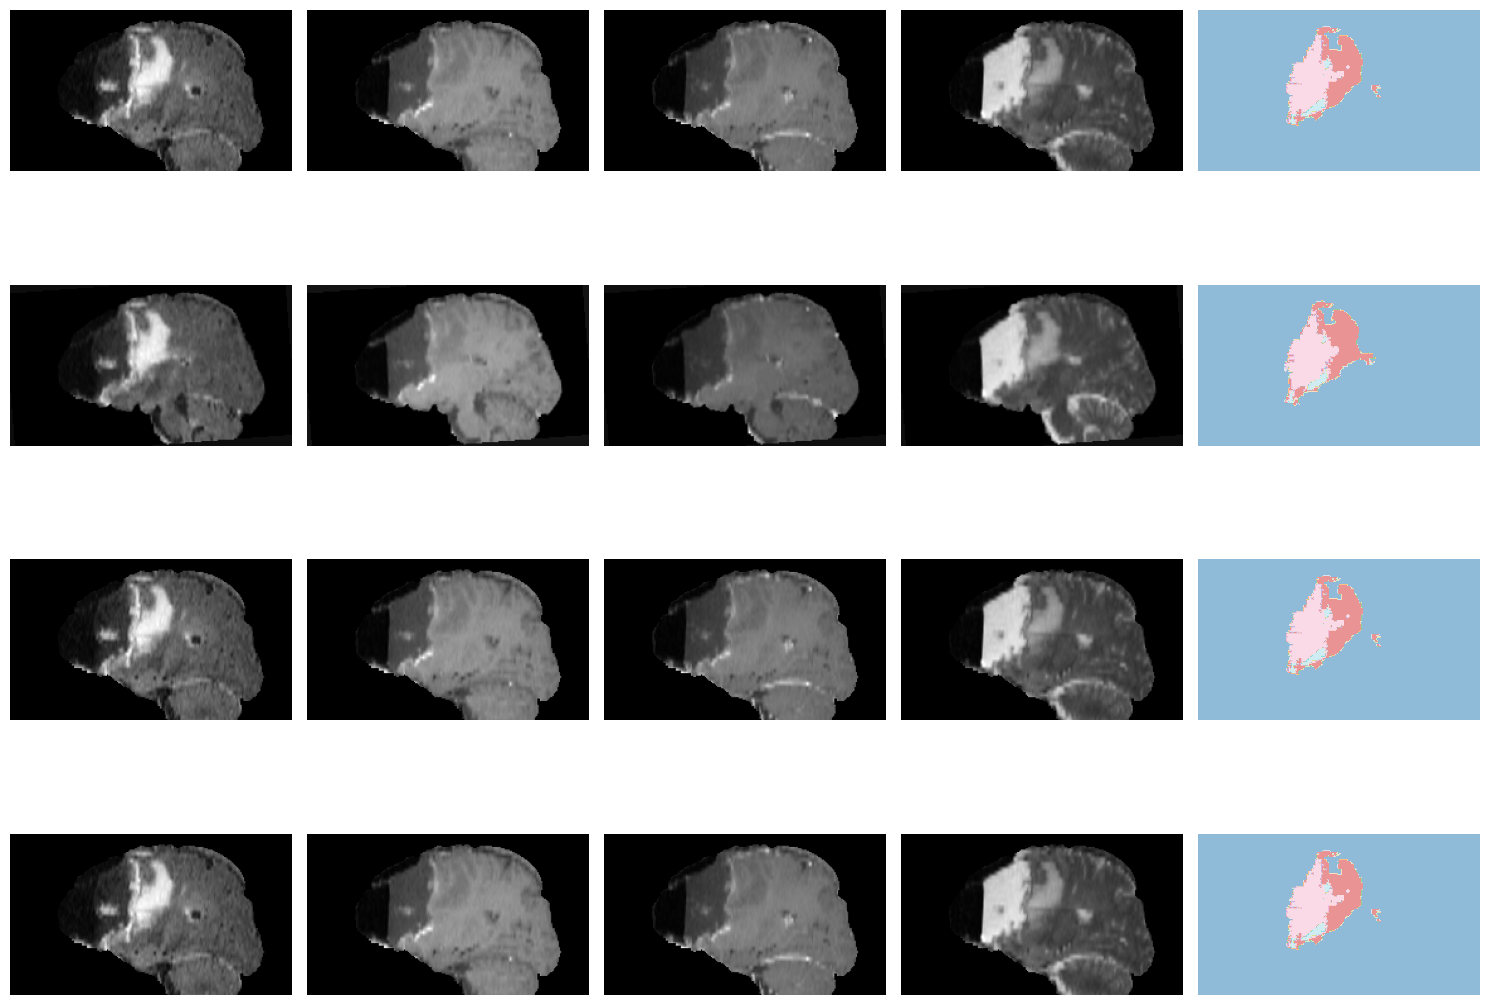

In [118]:
dls.show_batch(anatomical_plane=0, unique=True)

The code snippet `dls.show_batch(anatomical_plane=0, unique=True)` in the given cell is calling the `show_batch()` method on the `dls` object with two arguments: `anatomical_plane` and `unique`.

Here's a breakdown of the code:

- `dls` is assumed to be a `DataLoaders` object. It represents the data loading and processing pipeline for training data.
- The `.show_batch()` method is called on the `dls` object. This method is a fastMONAI-specific method that displays a batch of data samples from the dataset.
- `anatomical_plane=0` is an argument passed to the `show_batch()` method. The specific meaning of this argument depends on the implementation of the `show_batch()` method. It refer to a specific anatomical plane or dimension of the data to display.
- `unique=True` is another argument passed to the `show_batch()` method. Again, the specific meaning of this argument depends on the implementation of the `show_batch()` method. It indicate whether to display only unique samples in the batch.

By executing this code, the `show_batch()` method is called on the `dls` object, and a batch of data samples is displayed. The specific content and format of the displayed batch depend on the implementation of the `show_batch()` method and the data in the `dls` object. The `anatomical_plane` and `unique` arguments control the specific aspects of the displayed batch, such as the anatomical plane or the uniqueness of the samples.

Here's an other batch of data (unique=False):

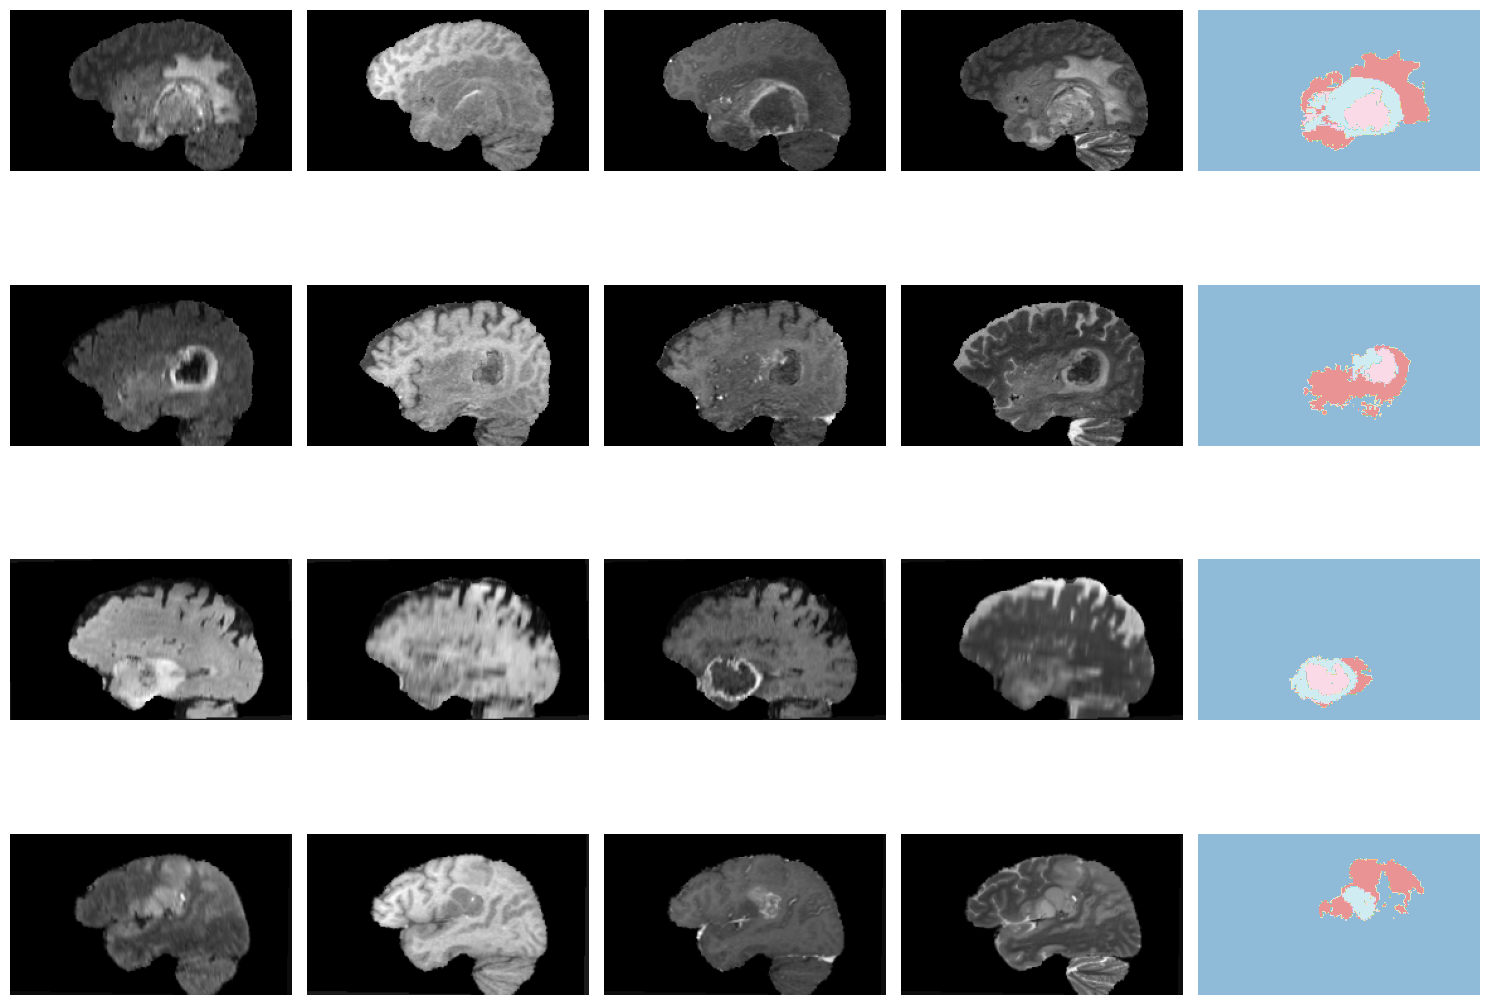

In [119]:
dls.show_batch(anatomical_plane=0) 

# Create and train a model for 3D image data

The current state-of-the-art CNN models for medical image segmentation tasks are based on encoder-decoder architectures like the U-Net. 
In the following line, we import an enhanced version of 3D UNet from MONAI. 

## Model architecture

We use an enhanced version of UNet from MONAI. 

Here's an illustration of the basic UNet architecture on which our model is built:

<img src="./assets/unet.jpeg">

The `UNet`` architecture in MONAI is a popular and widely used convolutional neural network (CNN) architecture for semantic segmentation tasks. It is designed to effectively capture both local and global contextual information in an image.

Here's an overview of the different components of the UNet architecture in MONAI:

1. Input:
   - The input to the UNet architecture is typically an image or a volume with multiple channels, representing the input data for semantic segmentation.
   - The size of the input can vary depending on the specific application and dataset.

2. Encoder:
   - The encoder part of the UNet architecture consists of a series of down-sampling blocks.
   - Each down-sampling block typically consists of two or more convolutional layers followed by a non-linear activation function, such as ReLU.
   - The purpose of the encoder is to capture and extract high-level features from the input data while reducing the spatial dimensions.

3. Decoder:
   - The decoder part of the UNet architecture consists of a series of up-sampling blocks.
   - Each up-sampling block typically consists of an up-convolutional layer (also known as transposed convolution or deconvolution) followed by one or more convolutional layers.
   - The purpose of the decoder is to gradually up-sample the feature maps and recover the spatial resolution lost during the encoding stage.

4. Skip-Connections:
   - The UNet architecture incorporates skip-connections that connect the corresponding feature maps from the encoder to the decoder.
   - These skip-connections enable the decoder to access and utilize the low-level, fine-grained details captured by the encoder.
   - Skip-connections help in preserving spatial information and improving the segmentation accuracy, especially for small or thin structures.

5. Output:
   - The output of the UNet architecture is a segmentation map that assigns a class label to each pixel or voxel in the input image or volume.
   - The size of the output map is typically the same as the input, representing the predicted segmentation mask.

The UNet architecture in MONAI provides a powerful and flexible framework for semantic segmentation tasks. It effectively combines the encoding and decoding stages, along with skip-connections, to capture both local and global contextual information and produce accurate segmentation results.

In [124]:
from monai.networks.nets import UNet

The code in this cell is importing the `UNet` class from the `monai.networks.nets` module. 

By importing the `UNet` class, the code is making this class available for use in the current file. It suggests that the U-Net architecture will be used or referenced in the subsequent code.

## Loss function

The Dice coeffiecient measures the degree of overlap between the predicted tumor mask and the "ground truth" masks:

<img width=20% src="./assets/dice.png">

Alterntively, _dice loss_ this can be written: 
\begin{equation*}
\begin{aligned}
loss = 1- \frac{y \cap \hat{y}}{\left | y \right |+\left | \hat{y} \right |}
\end{aligned}
\end{equation*}

We use a loss function that **combines Dice loss** and **Cross Entropy loss** and returns the **weighted sum** of these two losses. 

In the context of MONAI, Dice loss and Cross Entropy loss are two commonly used loss functions for training deep learning models in various medical imaging tasks, including segmentation.

1. Dice Loss:
   - Dice loss, also known as the Sørensen-Dice coefficient or F1 loss, is a similarity-based loss function used for evaluating the overlap between predicted and ground truth segmentation masks.
   - The Dice loss measures the similarity between two sets $A$ and $B$ by computing the intersection ( $A \cap B$ ) and union ( $A \cup B$ ) of the sets.
   - In MONAI, the Dice loss is often used for binary or multi-class segmentation tasks.
   - The Dice loss is defined as 1 minus the Dice coefficient, which is computed as twice the intersection divided by the sum of the sizes of the predicted and ground truth masks.
   - The Dice loss encourages the model to produce segmentation masks that closely match the ground truth masks, with values closer to 0 indicating better alignment.

2. Cross Entropy Loss:
   - Cross Entropy loss, also known as log loss, is a commonly used loss function for classification tasks, including multi-class segmentation.
   - In MONAI, the Cross Entropy loss is often used when the segmentation task involves assigning each pixel or voxel to one of multiple classes.
   - The Cross Entropy loss measures the dissimilarity between the predicted class probabilities and the ground truth labels.
   - It computes the average negative log-likelihood of the predicted probabilities for the correct classes.
   - The Cross Entropy loss penalizes incorrect predictions more heavily, encouraging the model to assign higher probabilities to the correct classes.

More specifically: **Cross Entropy loss** measures the dissimilarity between the predicted class probabilities and the ground truth labels. <br>Mathematically, the Cross Entropy loss can be defined as follows:

Given a set of N samples with C classes, let's denote the predicted class probabilities as P and the ground truth labels as Y. The predicted class probabilities P can be represented as a matrix of shape (N, C), where each row corresponds to the predicted probabilities for a sample, and each column represents the predicted probability for a specific class.

The ground truth labels Y can be represented as a matrix of shape (N, C), where each row corresponds to the one-hot encoded representation of the ground truth label for a sample. In one-hot encoding, only the column corresponding to the true class label is 1, and all other columns are 0.

The Cross Entropy loss L for a single sample can be computed as:

L = - ∑(Y * log(P))

Here, the sum is taken over all C classes, and * denotes element-wise multiplication.

To obtain the average Cross Entropy loss over N samples, the individual losses are summed and divided by N:

L_avg = (1/N) * ∑(- ∑(Y * log(P)))

The goal during training is to minimize the Cross Entropy loss, which encourages the model to assign higher probabilities to the correct classes and penalizes incorrect predictions more heavily.

Both Dice loss and Cross Entropy loss are implemented in MONAI and can be used as loss functions during the training of deep learning models for medical image segmentation tasks. The choice between these loss functions depends on the specific requirements of the task, the nature of the data, and the desired behavior of the model.

In [126]:
from monai.losses import DiceCELoss

The code in this cell is importing the `DiceCELoss` class from the `monai.losses` module.

Here's a breakdown of the code:

- `from monai.losses import DiceCELoss`: This line of code imports the `DiceCELoss` class from the `monai.losses` module.
- `monai` refers to the MONAI library, which stands for Medical Open Network for AI. It is a domain-specific, open-source framework for deep learning in medical imaging.
- `losses` is a submodule within MONAI that provides various loss functions commonly used in medical imaging tasks.
- `DiceCELoss` is a specific loss function class that combines the Dice loss and Cross Entropy loss. It is designed for multi-class segmentation tasks and provides a trade-off between the two loss functions.

By executing this code, the `DiceCELoss` class is imported and can be used to define the loss function for training a deep learning model in the subsequent code. The `DiceCELoss` class encapsulates the logic and computation required for the combined Dice loss and Cross Entropy loss, making it convenient to use in MONAI-based projects.

**Check collection of unique labels and their cardinality:**

In [127]:
codes = np.unique(med_img_reader(train_df.label.tolist()[0]))
n_classes = len(codes)
codes, n_classes

(array([0., 1., 2., 3.], dtype=float32), 4)

In the first line, `codes` is assigned the result of applying the `np.unique()` function to the `train_df.label.tolist()[0]` expression. This expression retrieves the labels from the `train_df` DataFrame and converts them into a list. The `np.unique()` function then returns the unique elements from that list. The `codes` variable will contain an array of unique labels.

In the second line, `n_classes` is assigned the length of the `codes` array. This will give the number of unique classes or labels present in the `train_df.label.tolist()[0]` data.

Finally, in the third line, the `codes` array and `n_classes` value are printed as a tuple using the `print()` function. This will display the unique labels and the number of classes in the output.

In [128]:
model = UNet(
    spatial_dims=3, 
    in_channels=4, 
    out_channels=n_classes, 
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2), 
    num_res_units=2)

model = model.model

This code consists of two lines of code.

In the first line, a `UNet` model is instantiated and assigned to the variable `model`. The `UNet` class is being used to create a U-Net architecture for image segmentation tasks. The parameters passed to the `UNet` constructor are as follows:
- `spatial_dims=3`: This parameter specifies that the input data has three spatial dimensions, indicating that it is a 3D image.
- `in_channels=4`: This parameter specifies that the input data has four channels. Each channel may represent a different image modality or feature.
- `out_channels=n_classes`: This parameter specifies the number of output channels of the model, which is determined by the `n_classes` variable. `n_classes` represents the number of classes or labels in the segmentation task.
- `channels=(16, 32, 64, 128, 256)`: This parameter specifies the number of channels in each layer of the model. The values `(16, 32, 64, 128, 256)` indicate that the model has five layers, and the number of channels increases progressively from 16 to 256.
- `strides=(2, 2, 2, 2)`: This parameter specifies the stride values used for downsampling the feature maps in each layer. The values `(2, 2, 2, 2)` suggest that the spatial dimensions are halved in each layer.
- `num_res_units=2`: This parameter specifies the number of residual units in each layer of the model. Residual units are commonly used to improve the flow of gradients during training and enhance the model's representational capacity.

In the second line, the `model` attribute of the `model` object is assigned back to the `model` variable. This step is done to access the underlying neural network model for further operations or modifications.

In [129]:
# More details about the model (uncomment):
#model

In the given code excerpt, `model` refers to a variable or object that represents a machine learning model. The specific details of the model are not visible in the provided code snippet, as the line is commented out.

The purpose of the commented line `model` is to provide more details about the model. By uncommenting the line, the details of the model will be displayed, which can include information such as the architecture, parameters, layers, and other relevant properties of the model.

Uncommenting the line `model` allows you to inspect and understand the structure and specifications of the model being used in the code. It can be helpful for debugging, understanding the model's configuration, or gaining insights into its architecture and parameters.

In [130]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

The code in this cell assigns a value to the variable `loss_func`. It creates an instance of the `CustomLoss` class and initializes it with a specific loss function called `DiceCELoss`. 

The `DiceCELoss` is a combination of two loss functions: Dice Loss and Cross-Entropy Loss. It is commonly used for image segmentation tasks. 

The `CustomLoss` class is likely a custom implementation or wrapper around the `DiceCELoss` function, providing additional functionality or customization options. 

In this specific instantiation, the `DiceCELoss` is configured with the following parameters:
- `to_onehot_y=True`: This parameter indicates that the target labels should be converted to one-hot encoded format. One-hot encoding represents each class as a binary vector, where each element corresponds to a class and is either 0 or 1.
- `include_background=True`: This parameter specifies whether to include the background class in the loss calculation. The background class represents the regions of the image that do not belong to any specific class.
- `softmax=True`: This parameter indicates that the output of the model should be passed through a softmax activation function before calculating the loss. Softmax function normalizes the output values to represent class probabilities.


By using this `loss_func` in the training process, the model will be optimized based on the combination of Dice Loss and Cross-Entropy Loss, with the specified configurations for one-hot encoding, background inclusion, and softmax activation.

**Note on `softmax`**:

Softmax is a mathematical function that is commonly used in machine learning for multi-class classification tasks. It takes a vector of real-valued numbers as input and transforms them into a probability distribution over multiple classes.

The softmax function operates on a vector of logits, which are the unnormalized scores or values associated with each class. The softmax function normalizes these logits and converts them into probabilities that sum up to 1.

Mathematically, given a vector of logits `z = [z1, z2, ..., zn]`, the softmax function computes the probability `p` for each class `i` as follows:



In [ ]:
p_i = exp(z_i) / sum(exp(z_j)) for j = 1 to n



In this equation, `exp()` represents the exponential function, and `sum()` denotes the sum of the exponential values over all classes.

The softmax function exponentiates each logit and divides it by the sum of the exponentiated logits. This ensures that the resulting probabilities are positive and sum up to 1, representing a valid probability distribution.

The softmax function is commonly used as the final activation function in the output layer of a neural network for multi-class classification tasks. It allows the model to produce class probabilities that can be interpreted as the confidence or likelihood of each class given the input data.

**Note on `logits`**:

In machine learning, logits are the raw, unnormalized output values produced by a model before applying any activation function. Logits can be thought of as the scores or values associated with each class in a multi-class classification problem.

Logits are typically obtained from the last layer of a neural network model, which is often a linear layer or a fully connected layer. The logits represent the model's predictions or estimations for each class without any transformation or normalization.

Unlike probabilities, logits do not necessarily sum up to 1 or fall within a specific range. They can be positive, negative, or zero. The relative magnitudes of the logits provide information about the model's confidence or certainty for each class prediction.

Logits are often used as input to a softmax function or other activation functions to convert them into probabilities or to make them more interpretable. The softmax function is commonly used to transform logits into a probability distribution over multiple classes, where each class probability represents the likelihood or confidence of the corresponding class given the input data.

In summary, logits are the unnormalized output values produced by a model before applying an activation function, and they serve as the basis for generating class probabilities or making predictions in classification tasks.

**Here is an example of applying the softmax function to a vector of logits:**



In [132]:
import numpy as np

# Input logits
logits = np.array([2.0, 1.0, 0.5])

# Applying softmax function
softmax_output = np.exp(logits) / np.sum(np.exp(logits))

# Print the softmax probabilities
print(softmax_output)

[0.62853172 0.2312239  0.14024438]




Output:


In [ ]:
[0.66524096 0.24472847 0.09003057]



In this example, we have a vector of logits `[2.0, 1.0, 0.5]`. We apply the softmax function to these logits using the formula `exp(z_i) / sum(exp(z_j))` for each element in the vector.

After applying the softmax function, we obtain the softmax probabilities `[0.66524096, 0.24472847, 0.09003057]`. These probabilities represent the likelihood or confidence of each class given the input logits. The probabilities sum up to 1, forming a valid probability distribution over the classes.

## Train the model

Now we're ready to train the model. After training, we'll have something that can produce the following results on new, unseen MR recordings:

<img src="./assets/prediction_results.png" width=900>

<img src="./assets/pred_093.gif" width=400>

### Optimizer

> We use a built-in ranger optimizer from `fastai`, that combines (RAdam + Lookahead) into a single optimizer. <br>
> <i>Ranger21 tested with fastai available:</i> https://github.com/lessw2020/Ranger21

RAdam (Rectified Adam) and Lookahead are two optimization algorithms that aim to improve the training of deep learning models.

1. RAdam (Rectified Adam):
   - RAdam is an extension of the Adam optimizer, which is a popular adaptive learning rate optimization algorithm.
   - The key idea behind RAdam is to rectify the adaptive learning rate behavior of Adam by dynamically adjusting the variance of the adaptive learning rate.
   - RAdam introduces a term called "RAdam warmup" to stabilize the adaptive learning rate during the initial training steps.
   - It also incorporates a rectification term that corrects the bias introduced by the adaptive learning rate estimation.
   - RAdam has been shown to provide faster convergence and better generalization performance compared to traditional Adam optimizer in some cases.

2. Lookahead:
   - Lookahead is an optimization algorithm that aims to improve the convergence and generalization of deep learning models.
   - It combines the benefits of two optimization methods: the fast convergence of SGD (Stochastic Gradient Descent) with momentum and the stability of Adam.
   - Lookahead operates by maintaining two sets of weights: the "slow weights" and the "fast weights".
   - The "slow weights" are updated using a slower learning rate and act as a long-term memory of the optimization process.
   - The "fast weights" are updated using a faster learning rate and are used to explore the optimization landscape.
   - The "slow weights" are periodically updated to the current "fast weights" to improve stability and convergence.
   - Lookahead has been shown to improve the generalization performance and convergence speed of deep learning models, especially when combined with other optimization algorithms like SGD with momentum or Adam.

Both RAdam and Lookahead are optimization algorithms that can be used as alternatives to traditional optimization methods like SGD, Adam, or RMSprop. They aim to address some of the limitations and challenges associated with training deep learning models and have shown promising results in certain scenarios. However, the effectiveness of these algorithms may vary depending on the specific task, dataset, and model architecture, so it is recommended to experiment and evaluate their performance in your specific use case.

**Note on the Ranger21 optimizer**

Going into the details of the Ranger21 optimizer described in the paper titled "Ranger21: A Synergistic Optimizer combining RAdam (Rectified Adam) and Lookahead for Training Deep Neural Networks," which you can find on arXiv at https://arxiv.org/abs/2106.13731. This optimizer aims to enhance the training of deep neural networks, and it's particularly relevant to your interests in GenAI and computational medicine.

**1. Background:**
Ranger21 is an optimizer designed to improve upon the shortcomings of existing optimizers like Adam, Rectified Adam (RAdam), and Lookahead. It combines the strengths of RAdam and Lookahead to achieve better convergence and generalization in deep neural network training.

**2. RAdam (Rectified Adam):**
RAdam is an optimization algorithm that adjusts the learning rates dynamically during training to accelerate convergence. It addresses the issue of high learning rates at the beginning of training, which can lead to poor convergence. RAdam introduces a mechanism to rectify this by adapting the learning rate based on the gradient statistics.

**3. Lookahead:**
Lookahead is another optimizer that enhances the training process by introducing an auxiliary set of "slow-moving" parameters. It allows the optimizer to explore the loss landscape more effectively, leading to improved generalization.

**4. Ranger21 Components:**
Ranger21 combines RAdam and Lookahead in a synergistic manner. Here's how it works:

   - **RAdam Core:** Ranger21 uses RAdam as its core optimizer, which dynamically adjusts learning rates. This helps in handling the issue of aggressive learning rates at the start of training.

   - **Lookahead Mechanism:** On top of RAdam, Ranger21 incorporates the Lookahead mechanism. It maintains a "fast-moving" set of parameters and a "slow-moving" set. The fast-moving parameters are updated using RAdam, while the slow-moving parameters are updated more slowly. This combination allows for better exploration of the loss landscape.

**5. Benefits of Ranger21:**
   - **Faster Convergence:** Ranger21 adapts learning rates dynamically, which can lead to quicker convergence during training.
   - **Improved Generalization:** The Lookahead mechanism helps in finding better minima in the loss landscape, potentially improving the model's generalization performance.

**6. Critique:**
   - **Computational Overhead:** One drawback of Ranger21 is that it introduces additional computational overhead due to the Lookahead mechanism. This can make it slower than some other optimizers, especially on large models and datasets.

In summary, Ranger21 is an optimizer that combines the strengths of RAdam and Lookahead to enhance the training of deep neural networks. It provides faster convergence and improved generalization. However, it comes with a computational cost. Researchers and practitioners should consider using it when the benefits of enhanced convergence and generalization outweigh the added computation time.

Remember, when implementing Ranger21 or any new optimizer in your GenAI or computational medicine research, it's essential to experiment and evaluate its performance on your specific tasks and datasets to determine if it offers significant advantages over other optimizers.

**Key Takeaways:**
- Ranger21 is an optimizer that combines RAdam and Lookahead.
- It offers faster convergence and improved generalization.
- The Lookahead mechanism can introduce computational overhead.
- Evaluate its performance on your specific tasks and datasets.

### Learner class (in the fastai library)

The `Learner` class in the fastai library is a fundamental component used for training deep learning models. It provides a high-level interface for training neural networks, handling data, defining loss functions, and managing various aspects of the training process. Let's explore the key aspects and functionality of the `Learner` class:

1. **Data Management:**
   - `Learner` encapsulates the data pipeline and data loaders. It can handle various data types, including images, text, tabular data, and more.
   - It provides an easy way to load, preprocess, and augment data using fastai's data block API.

2. **Model Definition:**
   - You can specify the neural network architecture to be trained using the `model` parameter when creating a `Learner` instance.
   - `Learner` supports a wide range of pre-defined models and custom model architectures.

3. **Loss Function:**
   - You can specify the loss function using the `loss_func` parameter. fastai provides a variety of loss functions for different tasks, such as classification, regression, and segmentation.

4. **Optimization and Training:**
   - `Learner` handles the optimization process, including selecting an optimizer (e.g., SGD, Adam) and setting hyperparameters.
   - It includes methods like `fit`, `fit_one_cycle`, and `lr_find` for training the model.
   - The `fit` method supports various training configurations, including custom learning rate schedules and callbacks.

5. **Metrics and Evaluation:**
   - You can specify evaluation metrics using the `metrics` parameter. These metrics are used to assess the model's performance during training and validation.
   - `Learner` provides methods to evaluate the model on a validation set and generate predictions.

6. **Callbacks:**
   - Callbacks are functions that can be attached to the `Learner` to customize and control the training process. They can be used for early stopping, learning rate schedules, and more.
   - fastai includes a range of built-in callbacks, and you can create custom callbacks as well.

7. **Transfer Learning:**
   - `Learner` supports transfer learning, allowing you to fine-tune pre-trained models on new tasks with minimal effort.
   - You can load pre-trained weights and modify the architecture as needed.

8. **Training Loop:**
   - Under the hood, `Learner` manages the training loop, including forward and backward passes, weight updates, and logging of training statistics.

9. **Interpretability:**
   - fastai provides tools for model interpretation, including techniques for visualizing model predictions and identifying important features.

Here's a simplified example of creating a `Learner` for image classification:

```python
from fastai.vision.all import *

# Define data loaders
data = ImageDataLoaders.from_folder(path, train='train', valid='valid')

# Create a Learner instance
learn = cnn_learner(data, resnet34, metrics=accuracy)

# Train the model
learn.fine_tune(4)
```

In this example:
- `ImageDataLoaders` is used to prepare data.
- `cnn_learner` creates a `Learner` for image classification with a ResNet-34 architecture.
- `fine_tune` is used to fine-tune the model on the data.

The `Learner` class simplifies the training process, making it easier to experiment with different models, data, and training configurations while still allowing for fine-grained control when needed.

**Key Takeaways:**
- The `Learner` class in fastai is a high-level interface for training deep learning models.
- It handles data management, model definition, loss functions, optimization, and evaluation.
- Callbacks can be used to customize the training process.
- fastai supports various data types and tasks, making it versatile for deep learning projects.

In [133]:
%%time
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=multi_dice_score)#.to_fp16()

CPU times: user 0 ns, sys: 838 µs, total: 838 µs
Wall time: 848 µs


In the given code excerpt, `Learner` refers to a class or object that is being instantiated. It is likely a part of a machine learning framework or library, such as fastai or MONAI.

A `Learner` is typically responsible for managing the training process of a machine learning model. It encapsulates various components and functionalities required for training, such as the model architecture, data loaders, loss function, optimizer, and evaluation metrics.

In this specific code snippet, a `Learner` object is being created with the following parameters:

- `dls`: It represents the data loaders, which are responsible for loading and preprocessing the training and validation data.
- `model`: It represents the machine learning model that will be trained.
- `loss_func`: It specifies the loss function that will be used to measure the discrepancy between the predicted outputs and the actual targets during training.
- `opt_func`: It specifies the optimizer function that will be used to update the model's parameters based on the computed gradients.
- `metrics`: It specifies the evaluation metric(s) that will be used to assess the performance of the model during training.

The `Learner` object is then assigned to the variable `learn`, which can be used to perform various training-related operations, such as training the model, making predictions, and evaluating the model's performance.

In the following `learn.summary()` the terms that appear include:

- Layer Name: The name or identifier of each layer in the model.
- Output Shape: The shape or dimensions of the output produced by each layer.
- Param # or Parameters: The number of trainable parameters in each layer, which represents the number of learnable weights and biases.
- Non-trainable params: The number of non-trainable parameters, such as those in frozen layers or fixed components.
- Total params: The total number of parameters in the model, which is the sum of trainable and non-trainable parameters.
- Trainable: Indicates whether the parameters in a particular layer are trainable or not.
- Activation Function: The type of activation function used in each layer, such as ReLU, sigmoid, or softmax.

In [134]:
learn.summary()

Sequential (Input shape: 4 x 4 x 224 x 224 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 16 x 112 x 112  
Conv3d                                    1744       True      
InstanceNorm3d                            0          False     
Dropout                                                        
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
Dropout                                                        
PReLU                                     1          True      
Conv3d                                    1744       True      
____________________________________________________________________________
                     4 x 32 x 56 x 56 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
Dropout              

#### Learning rate

In the context of fastMONAI, the learning rate refers to a hyperparameter that determines the step size at which the model's parameters are updated during the training process. It controls the magnitude of the adjustments made to the model's weights and biases based on the computed gradients.

Here's a brief explanation of the learning rate in MONAI:

- Learning Rate: The learning rate is a scalar value that determines the proportion of the gradient by which the model's parameters are updated during each training iteration.
- Importance: The learning rate plays a crucial role in training deep learning models. A higher learning rate can result in faster convergence, but it may risk overshooting the optimal solution. Conversely, a lower learning rate can lead to slower convergence but potentially better fine-tuning of the model's parameters.
- Hyperparameter Tuning: The learning rate is a hyperparameter that needs to be carefully chosen based on the specific dataset, model architecture, and optimization algorithm being used. It often requires experimentation and tuning to find an optimal learning rate that balances convergence speed and model performance.
- Learning Rate Scheduling: In addition to choosing a fixed learning rate, MONAI also supports learning rate scheduling techniques, such as reducing the learning rate over time (learning rate decay) or adapting it dynamically based on the model's performance (learning rate annealing).

In summary, the learning rate in MONAI determines the step size for updating the model's parameters during training. It is a critical hyperparameter that affects the convergence speed and performance of the deep learning model.

**We might want to use the model and the dataset to find a reasonable learning rate value `automatically`**

For this, we can use the learning rate finder from fastai.

CPU times: user 50.9 s, sys: 28.7 s, total: 1min 19s
Wall time: 3min 22s


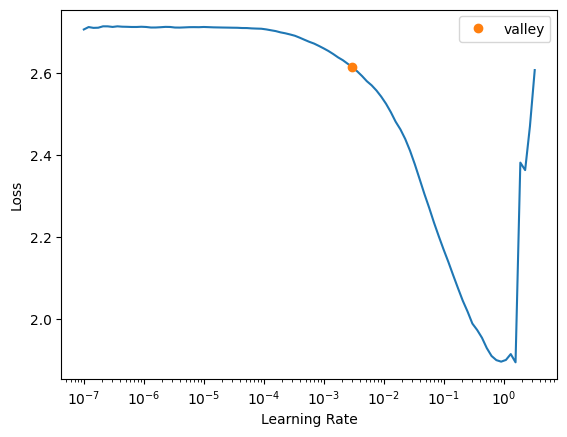

In [135]:
%%time
if not (is_colab):
    lr = learn.lr_find()  # 3 min 22 s on Ubuntu laptop
else:
    lr = 8e-4

In the given code excerpt, the learning rate (LR) is being automatically estimated using the `lr_find()` method in the fastai library. The `lr_find()` method is a commonly used technique to determine an appropriate learning rate for training a deep learning model.

Here's an explanation of the code:

- `%%time` is a Jupyter Notebook magic command that measures and displays the execution time of the code cell.
- The `if not (is_colab)` condition checks if the code is running outside of a Google Colab environment. This condition is likely used to handle different LR estimation approaches based on the execution environment.
- If the code is not running in a Google Colab environment, the LR is estimated using the `lr_find()` method. This method performs a short training run, gradually increasing the learning rate, and records the corresponding loss values.
- The purpose of the `lr_find()` method is to identify a learning rate that results in the steepest descent of the loss function. This learning rate is often referred to as the "learning rate range" or "learning rate slice."
- By analyzing the recorded loss values, one can determine an appropriate learning rate for training the model. Typically, the learning rate is chosen at a point where the loss is decreasing rapidly but has not started to diverge or plateau.
- If the code is running in a Google Colab environment (`is_colab` is True), a specific LR value of 8e-4 is assigned directly without performing the LR estimation.

By executing this code, the `lr_find()` method estimates an appropriate learning rate based on the loss values obtained during a short training run. This estimated learning rate can then be used for training the deep learning model in subsequent steps.

#### Epochs

In the context of machine learning, an **epoch** refers to a complete pass or iteration through the entire training dataset during the training phase of a model. It is a fundamental concept in the iterative optimization process of training a machine learning model.

Here's a breakdown of the concept of epochs:

- Training Dataset: The training dataset consists of a collection of labeled examples or samples that are used to train a machine learning model. Each example in the dataset consists of input features and corresponding target labels.

- Iterative Training: During the training phase, the model is exposed to the training dataset in multiple iterations or epochs. In each epoch, the model processes the entire training dataset, making predictions based on the current model parameters and adjusting the parameters based on the computed loss or error.

- Batch Processing: In practice, the training dataset is often divided into smaller subsets called batches. Each batch contains a fixed number of examples, and the model processes one batch at a time. The model's parameters are updated based on the average loss computed over the examples in the batch.

- Multiple Epochs: To improve the model's performance and convergence, the training process typically involves multiple epochs. In each epoch, the model goes through the entire training dataset, processing all the batches and updating the parameters based on the computed losses.

- Convergence: The number of epochs required for a model to converge depends on various factors, including the complexity of the problem, the size of the dataset, and the architecture of the model. Training for too few epochs may result in underfitting, while training for too many epochs may lead to overfitting.

In summary, an epoch represents a complete pass through the entire training dataset during the training phase of a machine learning model. It allows the model to learn from the entire dataset in an iterative manner, gradually improving its performance and convergence over multiple epochs.

**In the interest of time, our model is trained for only a few epochs. If you have the time, you can raise this number to something higher (f.ex. `epochs=30` or more) to get a model that performs much better**.

In [156]:
epochs = 100

#### Explaining the training process using fastai `fit_flat_cos``

> As shown in https://walkwithfastai.com/Segmentation, with the ranger optimizer, we want to use a different fit function, called `fit_flat_cos`, i.e. fit self.model for `n_epoch` at flat `lr` before a cosine annealing.

**Cosine annealing** is a learning rate scheduling technique commonly used in deep learning training to improve the convergence and generalization of neural networks. It's called "cosine annealing" because the learning rate follows a cosine curve during training. Here's how it works:

1. **Learning Rate Initialization:** At the beginning of training, you typically start with a relatively high learning rate. This helps the model explore the parameter space more quickly and make larger weight updates.

2. **Annealing Schedule:** Instead of keeping the learning rate constant throughout training, cosine annealing gradually reduces it. The reduction follows a cosine curve, which means that the learning rate decreases in a smooth and periodic manner.

3. **Advantages of Cosine Annealing:**
   - **Stable Training:** Cosine annealing provides a more stable and controlled learning rate reduction compared to fixed learning rates or other annealing strategies.
   - **Improved Convergence:** The gradual decrease in the learning rate allows the model to converge to a more optimal solution. It helps the model escape poor local minima by allowing it to make finer weight adjustments as training progresses.
   - **Regularization Effect:** The periodic nature of the learning rate can act as a form of regularization, preventing overfitting and potentially improving the model's generalization performance.
   - **Reusability:** Cosine annealing can be applied to various deep learning tasks without extensive hyperparameter tuning, making it a versatile scheduling strategy.

4. **Implementation:**
   - In practice, cosine annealing is often combined with other learning rate policies, such as warm-up phases or flat annealing phases, as seen in `fit_flat_cos` from the fastai library, which I explained in a previous response.
   - The key hyperparameter to control cosine annealing is the total number of training iterations or epochs over which the cosine curve completes a full cycle.

5. **Visualization:** The learning rate schedule in cosine annealing resembles a half-cycle of a cosine curve. It starts high, decreases smoothly to a minimum value, and then increases again for the next cycle.

6. **Customization:** Practitioners can customize the specifics of cosine annealing, such as the minimum and maximum learning rates, the length of the annealing schedule, and the number of cycles. These parameters can be adjusted based on the specific characteristics of the dataset and model being trained.

In summary, cosine annealing is a learning rate scheduling technique that gradually reduces the learning rate during deep learning training in a smooth, periodic manner. It helps improve model convergence, stability, and generalization by allowing the model to explore the loss landscape more effectively. It's a valuable tool in the training arsenal for neural networks.

In fastai, `fit_flat_cos` is used for training deep learning models and is particularly useful for fine-tuning neural networks.

**1. Purpose:**
`fit_flat_cos` is a training function in fastai that implements a variant of the one-cycle learning rate policy. This policy is designed to efficiently train deep neural networks by using a cyclical learning rate schedule with a flat annealing phase.

**2. Cyclical Learning Rate Policy:**
The cyclical learning rate policy involves cyclically increasing and decreasing the learning rate during training. It consists of two phases:
   - **Warm-up Phase:** Initially, the learning rate starts at a small value and gradually increases in each mini-batch or epoch. This phase helps the model to converge quickly in the beginning.
   - **Annealing Phase:** After the warm-up phase, the learning rate is gradually reduced, allowing the model to fine-tune its parameters more precisely.

**3. `fit_flat_cos` Function:**
`fit_flat_cos` is an extension of this policy that includes a flat annealing phase. Here's how it works:

   - **Warm-up Phase:** Similar to the standard cyclical learning rate policy, the learning rate starts low and increases during the warm-up phase. This helps the model to quickly find a good solution.
   
   - **Flat Annealing Phase:** After the warm-up, the learning rate remains constant (flat) for a certain number of epochs. During this phase, the model continues training with a fixed learning rate, which allows it to further refine its parameters.

   - **Cosine Annealing Phase:** After the flat annealing phase, the learning rate is reduced in a cosine annealing manner. This slow reduction helps the model to converge to a more optimal solution.

**4. Benefits:**
   - **Efficient Training:** `fit_flat_cos` helps in efficient and effective training of deep learning models. The warm-up phase prevents the model from getting stuck in poor local minima, while the flat annealing phase allows for further fine-tuning.
   
   - **Regularization:** The cyclical nature of the learning rate can act as a form of regularization, preventing overfitting and potentially improving generalization.

**5. Usage:**
In fastai, you can use `fit_flat_cos` when calling the `Learner` class's `fit_one_cycle` method. Here's an example of how you might use it:

```python
learn.fit_one_cycle(cyc_len=10, max_lr=slice(1e-5, 1e-3))
```

In this example, `fit_one_cycle` uses a learning rate schedule similar to `fit_flat_cos`, where `cyc_len` specifies the total number of epochs, and `max_lr` defines the range of learning rates during the warm-up phase.

**6. Critique:**
   - **Sensitivity to Parameters:** The effectiveness of the one-cycle policy, including `fit_flat_cos`, can be sensitive to the choice of hyperparameters, such as the learning rate range and the length of each phase. Careful experimentation may be required to find optimal settings for a specific task.

In summary, `fit_flat_cos` is a training function in the fastai library that implements a variant of the one-cycle learning rate policy. It efficiently trains deep learning models by combining warm-up, flat annealing, and cosine annealing phases, allowing for quick convergence and fine-tuning. However, it may require careful parameter tuning for optimal results in practice.

**Key Takeaways:**
- `fit_flat_cos` is used for training deep learning models in fastai.
- It implements a one-cycle learning rate policy with a flat annealing phase.
- The policy consists of warm-up, flat annealing, and cosine annealing phases.
- It efficiently finds good solutions and can act as a regularization technique.
- Parameter tuning may be needed for optimal results.

```bash
$ nvidia-smi -l 1

+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|

|    0   N/A  N/A      2589      G   /usr/lib/xorg/Xorg                           69MiB |
|    0   N/A  N/A      2767    C+G   ...libexec/gnome-remote-desktop-daemon      161MiB |
|    0   N/A  N/A     12622      C   .../anaconda3/envs/elmed219/bin/python    10298MiB |
|    0   N/A  N/A     20984    C+G   ...seed-version=20231218-080113.411000       65MiB |
+---------------------------------------------------------------------------------------+
Mon Jan  1 00:35:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000 Laptop GPU    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   65C    P0              60W /  90W |  10623MiB / 16384MiB |     27%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
```

In [157]:
%%time
#learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.250088,0.288903,"tensor([0.7458, 0.5470, 0.7190])",02:26
1,0.251937,0.276784,"tensor([0.7635, 0.5581, 0.7349])",02:32
2,0.251661,0.280691,"tensor([0.7618, 0.5472, 0.7302])",02:32
3,0.249874,0.278263,"tensor([0.7655, 0.5548, 0.7281])",02:34
4,0.244759,0.282122,"tensor([0.7660, 0.5431, 0.7199])",02:25
5,0.249583,0.271642,"tensor([0.7705, 0.5608, 0.7361])",02:26
6,0.243419,0.286631,"tensor([0.7454, 0.5496, 0.7325])",02:27
7,0.243495,0.288131,"tensor([0.7630, 0.5545, 0.6872])",02:29
8,0.240403,0.271179,"tensor([0.7763, 0.5449, 0.7508])",02:27
9,0.243544,0.270517,"tensor([0.7711, 0.5502, 0.7492])",02:30


CPU times: user 1h 8min 28s, sys: 35min 40s, total: 1h 44min 8s
Wall time: 4h 9min 5s


```python
epoch	train_loss	valid_loss	multi_dice_score	time
0	0.250088	0.288903	tensor([0.7458, 0.5470, 0.7190])	02:26
1	0.251937	0.276784	tensor([0.7635, 0.5581, 0.7349])	02:32
2	0.251661	0.280691	tensor([0.7618, 0.5472, 0.7302])	02:32
3	0.249874	0.278263	tensor([0.7655, 0.5548, 0.7281])	02:34
4	0.244759	0.282122	tensor([0.7660, 0.5431, 0.7199])	02:25
5	0.249583	0.271642	tensor([0.7705, 0.5608, 0.7361])	02:26
6	0.243419	0.286631	tensor([0.7454, 0.5496, 0.7325])	02:27
7	0.243495	0.288131	tensor([0.7630, 0.5545, 0.6872])	02:29
8	0.240403	0.271179	tensor([0.7763, 0.5449, 0.7508])	02:27
9	0.243544	0.270517	tensor([0.7711, 0.5502, 0.7492])	02:30
10	0.238784	0.262915	tensor([0.7787, 0.5762, 0.7449])	02:31
11	0.237816	0.265289	tensor([0.7748, 0.5743, 0.7473])	02:30
12	0.234363	0.273158	tensor([0.7682, 0.5474, 0.7511])	02:30
13	0.237404	0.263721	tensor([0.7701, 0.5808, 0.7485])	02:29
14	0.236626	0.265251	tensor([0.7747, 0.5711, 0.7437])	02:27
15	0.235877	0.284552	tensor([0.7602, 0.5254, 0.7436])	02:26
16	0.234888	0.288180	tensor([0.7278, 0.5423, 0.7410])	02:30
17	0.233050	0.259285	tensor([0.7793, 0.5857, 0.7474])	02:32
18	0.235576	0.265613	tensor([0.7756, 0.5742, 0.7389])	02:29
19	0.232239	0.270740	tensor([0.7744, 0.5562, 0.7429])	02:31
20	0.236297	0.260400	tensor([0.7764, 0.5859, 0.7411])	02:27
21	0.229970	0.265909	tensor([0.7823, 0.5601, 0.7490])	02:30
22	0.225732	0.256385	tensor([0.7777, 0.5988, 0.7465])	02:30
23	0.225850	0.257213	tensor([0.7831, 0.5832, 0.7536])	02:26
24	0.225272	0.268739	tensor([0.7758, 0.5495, 0.7540])	02:27
25	0.221830	0.254529	tensor([0.7805, 0.5944, 0.7542])	02:30
26	0.221526	0.258228	tensor([0.7797, 0.5889, 0.7487])	02:31
27	0.223391	0.268432	tensor([0.7731, 0.5593, 0.7526])	02:30
28	0.221289	0.259008	tensor([0.7790, 0.5789, 0.7522])	02:29
29	0.220121	0.259594	tensor([0.7799, 0.5803, 0.7578])	02:35
30	0.216516	0.263106	tensor([0.7803, 0.5792, 0.7471])	02:29
31	0.216694	0.259634	tensor([0.7634, 0.6038, 0.7461])	02:29
32	0.215522	0.250251	tensor([0.7820, 0.6053, 0.7568])	02:28
33	0.219350	0.264833	tensor([0.7675, 0.5780, 0.7469])	02:24
34	0.215415	0.273804	tensor([0.7720, 0.5639, 0.7228])	02:30
35	0.216827	0.254490	tensor([0.7833, 0.5945, 0.7533])	02:30
36	0.217353	0.272266	tensor([0.7626, 0.5735, 0.7298])	02:29
37	0.217077	0.287980	tensor([0.7262, 0.5719, 0.7222])	02:33
38	0.217624	0.248376	tensor([0.7845, 0.6130, 0.7531])	02:32
39	0.214552	0.270952	tensor([0.7636, 0.5917, 0.7213])	02:31
40	0.211479	0.250999	tensor([0.7856, 0.5982, 0.7595])	02:28
41	0.208981	0.256262	tensor([0.7850, 0.5887, 0.7472])	02:28
42	0.211274	0.259199	tensor([0.7774, 0.5946, 0.7427])	02:27
43	0.211747	0.272447	tensor([0.7740, 0.5324, 0.7585])	02:30
44	0.208969	0.256287	tensor([0.7751, 0.5915, 0.7581])	02:24
45	0.207804	0.256597	tensor([0.7694, 0.6062, 0.7519])	02:25
46	0.205903	0.253034	tensor([0.7779, 0.5964, 0.7620])	02:30
47	0.206435	0.249207	tensor([0.7808, 0.6054, 0.7599])	02:31
48	0.207961	0.268225	tensor([0.7556, 0.5912, 0.7446])	02:29
49	0.205669	0.255301	tensor([0.7704, 0.6077, 0.7523])	02:28
50	0.204025	0.251420	tensor([0.7853, 0.5972, 0.7625])	02:28
51	0.204310	0.249598	tensor([0.7778, 0.6082, 0.7595])	02:33
52	0.207318	0.259393	tensor([0.7781, 0.5803, 0.7554])	02:28
53	0.208531	0.251842	tensor([0.7805, 0.6008, 0.7629])	02:33
54	0.207521	0.254348	tensor([0.7748, 0.5870, 0.7668])	02:24
55	0.203915	0.251089	tensor([0.7819, 0.6043, 0.7619])	02:29
56	0.203025	0.247621	tensor([0.7846, 0.6048, 0.7669])	02:29
57	0.201096	0.258794	tensor([0.7620, 0.6076, 0.7488])	02:31
58	0.203370	0.255551	tensor([0.7771, 0.6003, 0.7531])	02:30
59	0.200935	0.247879	tensor([0.7872, 0.6017, 0.7645])	02:30
60	0.199807	0.262648	tensor([0.7676, 0.5906, 0.7399])	02:32
61	0.198611	0.248134	tensor([0.7826, 0.6145, 0.7545])	02:28
62	0.194471	0.243117	tensor([0.7896, 0.6146, 0.7655])	02:28
63	0.198414	0.250355	tensor([0.7743, 0.6138, 0.7663])	02:28
64	0.197262	0.256417	tensor([0.7713, 0.5929, 0.7554])	02:25
65	0.197628	0.248846	tensor([0.7830, 0.6040, 0.7619])	02:28
66	0.196203	0.271404	tensor([0.7606, 0.5826, 0.7276])	02:29
67	0.195756	0.249408	tensor([0.7814, 0.6042, 0.7651])	02:30
68	0.193942	0.254123	tensor([0.7727, 0.6041, 0.7537])	02:30
69	0.194313	0.251927	tensor([0.7844, 0.6001, 0.7580])	02:32
70	0.196674	0.254210	tensor([0.7806, 0.5958, 0.7537])	02:29
71	0.193994	0.251094	tensor([0.7801, 0.6057, 0.7533])	02:28
72	0.191165	0.255034	tensor([0.7842, 0.6030, 0.7380])	02:28
73	0.192850	0.252455	tensor([0.7745, 0.6054, 0.7584])	02:26
74	0.191252	0.244735	tensor([0.7804, 0.6146, 0.7701])	02:27
75	0.194464	0.250140	tensor([0.7812, 0.6001, 0.7594])	02:32
76	0.191266	0.245303	tensor([0.7818, 0.6050, 0.7749])	02:28
77	0.189085	0.253506	tensor([0.7836, 0.5967, 0.7563])	02:27
78	0.190234	0.248813	tensor([0.7837, 0.6033, 0.7682])	02:30
79	0.188841	0.247322	tensor([0.7829, 0.6082, 0.7637])	02:27
80	0.188447	0.245628	tensor([0.7880, 0.6095, 0.7654])	02:28
81	0.185062	0.250437	tensor([0.7852, 0.6093, 0.7495])	02:29
82	0.184975	0.244567	tensor([0.7862, 0.6132, 0.7671])	02:26
83	0.182319	0.242306	tensor([0.7911, 0.6128, 0.7713])	02:26
84	0.179801	0.248854	tensor([0.7834, 0.5985, 0.7694])	02:28
85	0.180304	0.246935	tensor([0.7849, 0.6060, 0.7652])	02:31
86	0.179118	0.244944	tensor([0.7854, 0.6061, 0.7724])	02:28
87	0.179115	0.249952	tensor([0.7879, 0.6075, 0.7535])	02:28
88	0.177821	0.247201	tensor([0.7875, 0.6048, 0.7610])	02:32
89	0.177664	0.242758	tensor([0.7879, 0.6153, 0.7695])	02:33
90	0.174612	0.247842	tensor([0.7885, 0.6075, 0.7591])	02:26
91	0.173893	0.244712	tensor([0.7874, 0.6120, 0.7651])	02:28
92	0.171263	0.242512	tensor([0.7898, 0.6131, 0.7696])	02:26
93	0.169926	0.246269	tensor([0.7874, 0.6100, 0.7636])	02:29
94	0.169310	0.242712	tensor([0.7870, 0.6148, 0.7710])	02:29
95	0.167853	0.245117	tensor([0.7873, 0.6121, 0.7651])	02:31
96	0.168505	0.244460	tensor([0.7878, 0.6120, 0.7668])	02:32
97	0.165111	0.244710	tensor([0.7880, 0.6120, 0.7657])	02:27
98	0.164748	0.244259	tensor([0.7880, 0.6123, 0.7666])	02:27
99	0.167741	0.244256	tensor([0.7880, 0.6125, 0.7665])	02:31

CPU times: user 1h 8min 28s, sys: 35min 40s, total: 1h 44min 8s
Wall time: 4h 9min 5s
```

In [158]:
learn.save('braintumor-model-epoch-100-20240101')

Path('models/braintumor-model-epoch-100-20240101.pth')

In [190]:
!ls -al ./models/braintumor-model-epoch-100-20240101.pth

-rw-rw-r-- 1 arvid arvid 77069905 jan.   1 08:51 ./models/braintumor-model-epoch-100-20240101.pth


The code in this cell is saving the trained model using the `save()` method of the `learn` object. The saved model will be stored with the filename "braintumor-model-20231231".

Here's a breakdown of the code:

- `learn` is an object that has been defined or instantiated in the active `.ipynb` file.
- The `.save()` method is called on the `learn` object to save the trained model to disk (in the `.pth` format for future use or deployment.

#### The `.pth` format for save and load PyTorch models

The `.pth` model format is a file format commonly used to **save and load PyTorch models**. It is a binary file format that stores the state of a PyTorch model, including the model's architecture, parameters, and other relevant information.

Here's a breakdown of the `.pth` model format:

- Model State: The `.pth` file contains the state of the model, which includes the values of all the model's parameters (weights and biases) and other internal states.
- Serialization: The model state is serialized using PyTorch's built-in serialization functionality, which converts the model state into a binary format that can be saved to disk.
- Compatibility: The `.pth` format is compatible with different versions of PyTorch, allowing models to be saved in one version and loaded in another without compatibility issues.
- Flexibility: The `.pth` format allows for saving and loading various types of PyTorch models, including models with custom architectures, pre-trained models, and models trained on specific tasks or datasets.
- Usage: To save a PyTorch model in the `.pth` format, you typically use the `torch.save()` function, passing in the model's state and the desired file path. To load a `.pth` model file, you use the `torch.load()` function, specifying the file path, which returns the model's state that can be used for inference or further training.

The `.pth` model format provides a convenient and efficient way to save and load PyTorch models, allowing for easy sharing, deployment, and further modification of trained models.

In [145]:
if (is_colab):
    print(f'is_colab: {is_colab}')
    #!wget https://www.dropbox.com/s/tmebx1m4q57tn7b/trained.braintumor-model.pth?dl=1
    #!mkdir models
    #!mv trained.braintumor-model.pth?dl=1 models/trained.braintumor-model.pth

In [146]:
#!wget https://www.dropbox.com/s/tmebx1m4q57tn7b/trained.braintumor-model.pth?dl=1

In [159]:
!ls -al models

total 150544
drwxrwxr-x 2 arvid arvid     4096 jan.   1 08:51 .
drwxrwxr-x 6 arvid arvid     4096 des.  31 16:47 ..
-rw-rw-r-- 1 arvid arvid 77067365 des.  31 22:47 braintumor-model-20231231.pth
-rw-rw-r-- 1 arvid arvid 77069905 jan.   1 08:51 braintumor-model-epoch-100-20240101.pth


In [51]:
#!mv trained.braintumor-model.pth?dl=1 models/trained.braintumor-model-Oct2022.pth

#### To continue training a PyTorch model, you can follow these general steps:

1. Load the Pretrained Model: If you have a pretrained model that you want to continue training, load the model's state using the `torch.load()` function. This will restore the model's architecture and parameters.

2. Set the Model to Training Mode: Use the `model.train()` method to set the model to training mode. This ensures that the model's parameters are updated during the training process.

3. Define the Loss Function: Specify the loss function that you want to use for training. This could be a predefined loss function from PyTorch or a custom loss function.

4. Define the Optimizer: Create an optimizer object, such as `torch.optim.SGD` or `torch.optim.Adam`, and pass the model's parameters to it. This optimizer will update the model's parameters based on the computed gradients during training.

5. Train the Model: Iterate over your training data in batches and perform the following steps:
   - Zero the Gradients: Before each batch, zero the gradients of the model's parameters using the optimizer's `zero_grad()` method.
   - Forward Pass: Pass the input data through the model to obtain the predictions.
   - Compute Loss: Calculate the loss between the predictions and the ground truth labels using the defined loss function.
   - Backward Pass: Perform backpropagation by calling the `loss.backward()` method. This computes the gradients of the model's parameters.
   - Update Parameters: Use the optimizer's `step()` method to update the model's parameters based on the computed gradients.
   - Repeat these steps for each batch in your training data.

6. Repeat for Multiple Epochs: Iterate over your training data for the desired number of epochs, repeating the training process described in step 5.

By following these steps, you can continue training a PyTorch model by loading a pretrained model, defining the loss function and optimizer, and iterating over your training data to update the model's parameters.

In [161]:
#learn.load('trained.braintumor-model-Oct2022')
learn.load('braintumor-model-epoch-100-20240101')

**Export model to `pkl` format**

The `.pkl` format refers to the pickle file format in Python. It is a binary file format used for serializing and deserializing Python objects. The name "pickle" is derived from the process of preserving or "pickling" objects for later use.

Here's an explanation of the `.pkl` format:

- Serialization: Pickling is the process of converting a Python object into a binary representation that can be stored or transmitted. This binary representation includes the object's data, attributes, and the information needed to reconstruct the object.
- Object Preservation: Pickling allows you to save the state of Python objects, such as models, data structures, or custom classes, to disk or other storage mediums. This enables you to store complex objects and retrieve them later without losing their internal structure or data.
- Flexibility: The `.pkl` format is versatile and can handle a wide range of Python objects, including built-in data types, user-defined classes, and even complex nested structures.
- Cross-Platform Compatibility: Pickle files can be used across different platforms and Python versions, allowing you to save objects in one environment and load them in another without compatibility issues.
- Usage: To save a Python object in the `.pkl` format, you typically use the `pickle.dump()` function, passing in the object and a file object or filename. To load a `.pkl` file and retrieve the object, you use the `pickle.load()` function, specifying the file object or filename.

The `.pkl` format provides a convenient way to store and retrieve Python objects, including models, data structures, and custom classes. It allows you to preserve the state of objects for later use, making it useful for tasks such as model checkpointing, data caching, or sharing objects between different Python programs.

In [196]:
#learn.save('trained.braintumor-model-n_epoch_1')
#learn.export('./models/trained.braintumor-model-Oct2022.pkl')
learn.export('./models/braintumor-model-epoch-100-20240101.pkl')

In [197]:
!ls -al ./models

total 169868
drwxrwxr-x 2 arvid arvid     4096 jan.   1 09:35 .
drwxrwxr-x 6 arvid arvid     4096 des.  31 16:47 ..
-rw-rw-r-- 1 arvid arvid 77067365 des.  31 22:47 braintumor-model-20231231.pth
-rw-rw-r-- 1 arvid arvid 19784346 jan.   1 10:55 braintumor-model-epoch-100-20240101.pkl
-rw-rw-r-- 1 arvid arvid 77069905 jan.   1 08:51 braintumor-model-epoch-100-20240101.pth


In [216]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In [219]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[240.0, 240.0, 155.0]

In [220]:
in_shape = (1, 4, img_size[0], img_size[1], img_size[2])
in_shape

(1, 4, 240.0, 240.0, 155.0)

In [221]:
#store_variables(pkl_fn='./models/vars-Oct2022.pkl', var_vals=[reorder, resample])
store_variables(pkl_fn='./models/vars-braintumor-model-epoch-100-20240101.pkl', size=in_shape, reorder=reorder, resample=resample)


In [199]:
#learn.summary()

# Evaluate results

Let's check how the model performs on some validation data:

In [252]:
#??learn.show_results

```python
learn.show_results(max_n=6, figsize=(7,8))
Signature: learn.show_results(ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs)
Docstring: Show some predictions on `ds_idx`-th dataset or `dl`
Source:   
    def show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
        b = dl.one_batch()
        _,_,preds = self.get_preds(dl=[b], with_decoded=True)
        dl.show_results(b, preds, max_n=max_n, **kwargs)
File:      ~/anaconda3/envs/elmed219/lib/python3.11/site-packages/fastai/learner.py
Type:      method
```

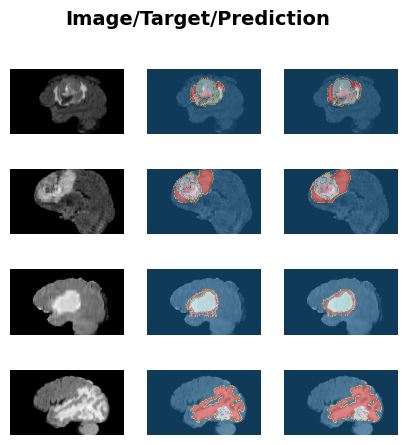

In [201]:
learn.show_results(anatomical_plane=0, ds_idx=0, figsize=(5,5))

The code `learn.show_results(anatomical_plane=0, ds_idx=0)` is calling the `show_results()` method on the `learn` object. It is passing two arguments: `anatomical_plane` and `ds_idx`.

Here's an explanation of the code:

- `learn` is assumed to be an object that has been defined or instantiated in the active `.ipynb` file. It is an instance of the `Learner` class in the fastai library.
- The purpose of the `show_results()` method is to display or visualize the results of the model's predictions on the specified dataset.
- `anatomical_plane=0` is an argument passed to the `show_results()` method. It specifies the anatomical plane to visualize. The value `0` corresponds to a sagittal, `1` to a coronal, and `2``to an axial anatomical plane.
- `ds_idx=0` is another argument passed to the `show_results()` method. It specifies the dataset index to show the results for. The value `0` indicates the first dataset within the available datasets.

By executing this code, the `show_results()` method will be called on the `learn` object, displaying or visualizing the results of the model's predictions for the specified anatomical plane and dataset. 

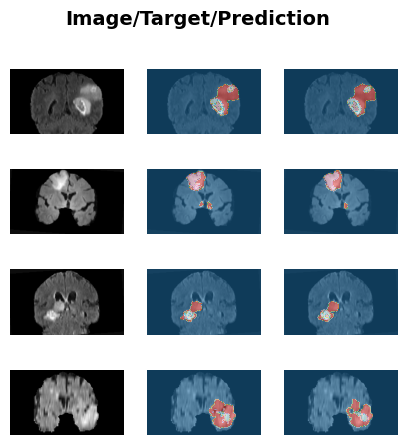

In [175]:
learn.show_results(anatomical_plane=1, ds_idx=0, figsize=(5,5))

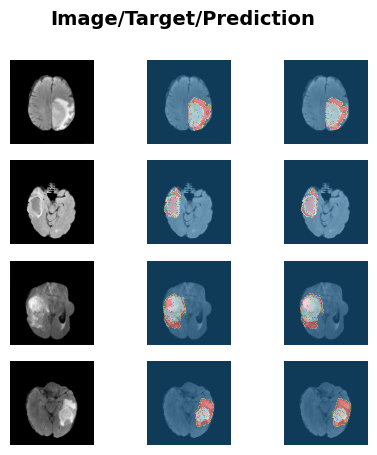

In [176]:
learn.show_results(anatomical_plane=2, ds_idx=0, figsize=(5,5))

Show another batch of results:

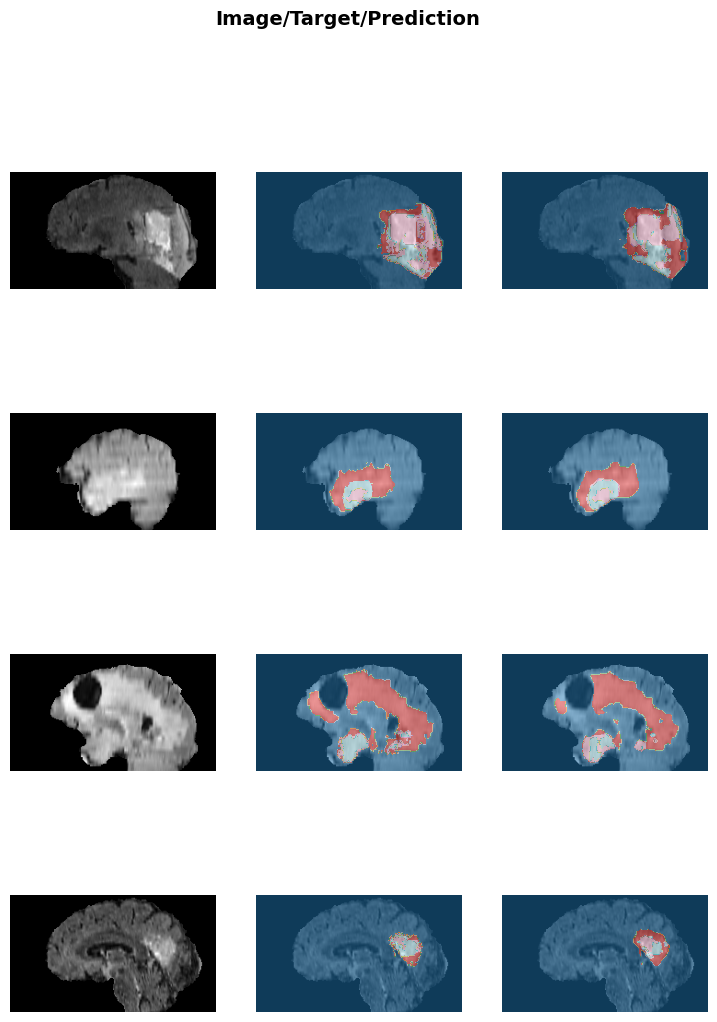

In [177]:
learn.show_results(anatomical_plane=0, ds_idx=1)

## Inference on test data

Remember that we also have some unseen test data that we can try our model on:

In [178]:
test_dl = learn.dls.test_dl(test_df[:10],with_labels=True)

Here are some examples from out test set:

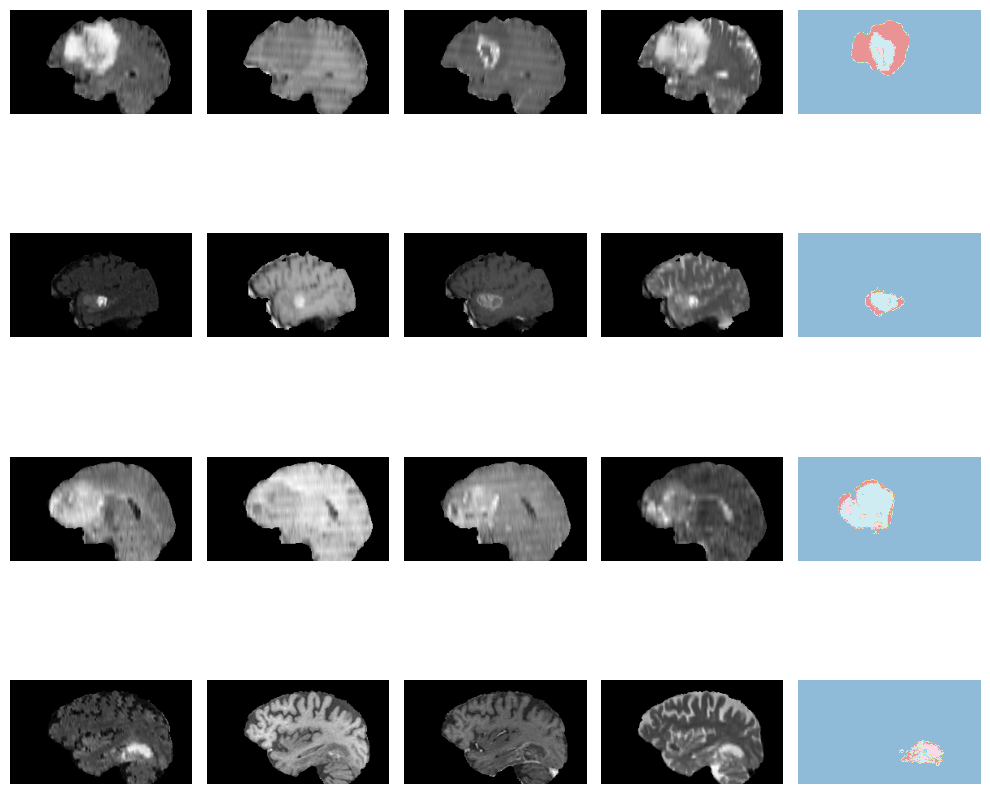

In [179]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

**Let's run the test set through our trained model:**

In [184]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([10, 4, 224, 224, 128]), torch.Size([10, 1, 224, 224, 128]))

**We can score the model using the Dice coefficient for the labels 1,2 and 3:** 

( n_epoch = 1 results in very poor perfomance on unseen data: `tensor([0.2108, 0.0081, 0.0040])` )

The model trained with x epochs for the Oct2022 seminar, gave: tensor([0.7252, 0.5850, 0.7106])


In [183]:
# Our model trained withh 100 epochs
multi_dice_score(pred_acts, labels)

tensor([0.7338, 0.5255, 0.7239])

Here are some of the results for inspection:

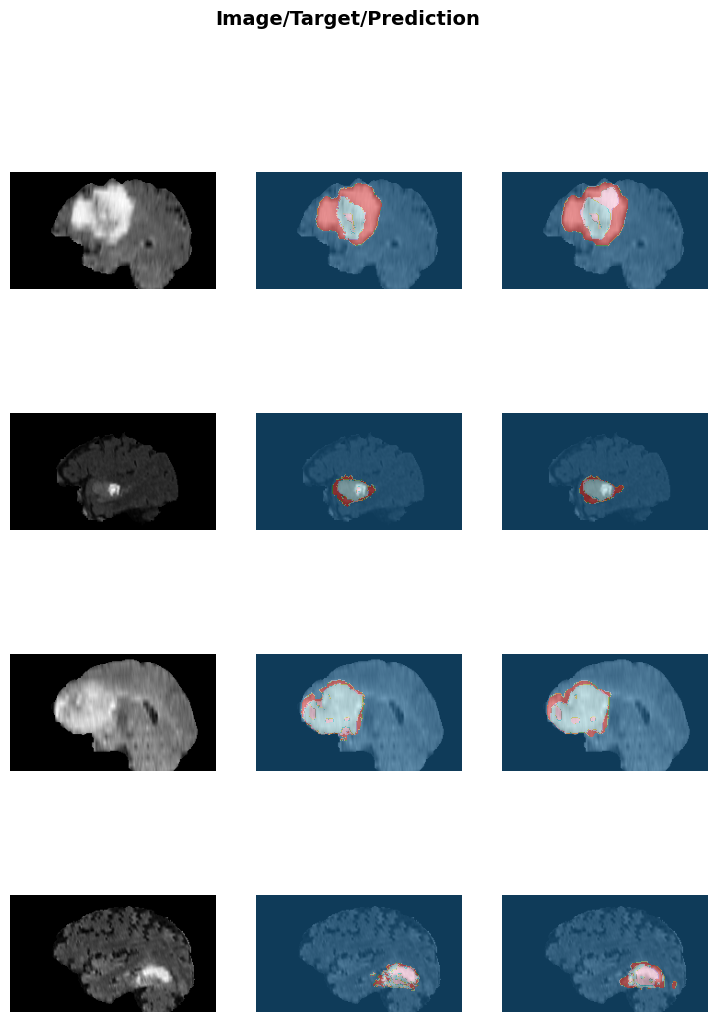

In [182]:
learn.show_results(anatomical_plane=0, dl=test_dl)

### Save segmentation results as Nifti  (.nii.gz) files

In [185]:
import os

save_path = Path('./data/results/braintumor')
#path.mkdir(parents=True, exist_ok=True)
if not os.path.exists(save_path):
    os.makedirs(save_path)


In [186]:
training_imgs = [data['image'] for data in training_data.data]
training_imgs[:10]

['data/Task01_BrainTumour/imagesTr/BRATS_442.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_389.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_380.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_245.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_453.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_252.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_078.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_427.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_421.nii.gz',
 'data/Task01_BrainTumour/imagesTr/BRATS_440.nii.gz']

In [187]:
test_data = DecathlonDataset(root_dir=path, task="Task01_BrainTumour", section="testing", download=True,
                                 cache_num=0, num_workers=8)

2024-01-01 09:29:16,111 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-01-01 09:29:16,111 - INFO - File exists: data/Task01_BrainTumour.tar, skipped downloading.
2024-01-01 09:29:16,111 - INFO - Non-empty folder exists in data/Task01_BrainTumour, skipped extracting.


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [188]:
test_imgs = [data['image'] for data in test_data.data]
test_imgs[:10]

['data/Task01_BrainTumour/imagesTs/BRATS_634.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_498.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_539.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_573.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_491.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_554.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_689.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_532.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_688.nii.gz',
 'data/Task01_BrainTumour/imagesTs/BRATS_627.nii.gz']

#### Inference on test data

Inference on test data refers to the process of using a trained model to make predictions or generate outputs on unseen or held-out test data. It is a crucial step in evaluating the performance and generalization of a machine learning model.

Here's a breakdown of the process of inference on test data:

1. Load the Trained Model: Load the trained model that you want to use for inference. This can be done by loading the model's saved state from a file or by instantiating the model class and loading the trained weights.

2. Prepare the Test Data: Preprocess and prepare the test data in a format that the model expects. This may involve resizing, normalizing, or transforming the test data to match the input requirements of the model.

3. Forward Pass: Pass the preprocessed test data through the loaded model using the model's forward method or by calling the predict method. This will generate predictions or outputs for the test data.

4. Post-processing: Depending on the specific task and model, you may need to perform post-processing on the model's outputs. This can include applying thresholding, decoding, or any other necessary transformations to obtain the final desired output format.

5. Evaluation or Analysis: Evaluate the model's predictions on the test data using appropriate evaluation metrics or analyze the outputs for further analysis or visualization. This step helps assess the model's performance and understand its behavior on unseen data.

By following these steps, you can perform inference on test data using a trained model. This allows you to generate predictions or outputs on unseen data and evaluate the model's performance and generalization capabilities.

Inference in `fastMONAI`:
```python
?inference

Signature:
inference(
    learn_inf,
    reorder,
    resample,
    fn: (<class 'str'>, <class 'pathlib.Path'>) = '',
    save_path: (<class 'str'>, <class 'pathlib.Path'>) = None,
    org_img=None,
    input_img=None,
    org_size=None,
)
Docstring: Predict on new data using exported model.
File:      ~/anaconda3/envs/elmed219/lib/python3.11/site-packages/fastMONAI/vision_inference.py
Type:      function
```


In [234]:
# learn_inf = load_learner('braintumor_model.pkl', cpu=False);
learn_inf = load_learner('./models/braintumor-model-epoch-100-20240101.pkl', cpu=False);

In [235]:
variables = load_variables(pkl_fn = './models/vars-braintumor-model-epoch-100-20240101.pkl')
_, reorder, resample = variables 
reorder, resample

(False, [1.0, 1.0, 1.0])

In [236]:
idx = 0
fn = test_imgs[idx]
fn

'data/Task01_BrainTumour/imagesTs/BRATS_634.nii.gz'

In [237]:
%%time
# mask = inference(learn_inf, reorder, resample, fn, save_path=save_path)
mask = inference(learn_inf, reorder, resample, fn, save_path=save_path)

CPU times: user 6.26 s, sys: 1.09 s, total: 7.35 s
Wall time: 1.34 s


In [250]:
print(str(mask), fn)

data/results/braintumor/pred_BRATS_634.nii.gz data/Task01_BrainTumour/imagesTs/BRATS_634.nii.gz


In [253]:
#from IPython.display import Image
#Image(filename="./assets/pred_BRATS_634.png")

**Dsiplay prediction using `freeview`**

```bash
~/ELMED219/Lab1-mpMRI-glioma/data/results/braintumor$ freeview -v BRATS_634.nii.gz pred_BRATS_634.nii.gz:colormap=lut:opacity=0.5
```
Crosshair: RAS (162, 68, 75)<br>



<img src=./assets/pred_BRATS_634_4chn.png width=1000>

# Export the model and dataloader

The final step is to export the model and the pre-processing steps so that they can be used in some further context:

In [254]:
# Previously done
# store_variables(pkl_fn='./models/vars-braintumor-model-epoch-100-20240101.pkl', size=in_shape, reorder=reorder, resample=resample)

In [255]:
# Previously done
# learn.export('./models/braintumor-model-epoch-100-20240101.pkl')

This model can then, in principle, be taken further into an infrastructure where it can be tested against new data. 

# Extra material: Radiomics

Once we've segmented tumors into meaningful subcompartments, we have a set of regions of interest (ROIs) and can start asking many interesting questions. Computing the tumor volumes is an obvious idea. We can also try to compute various shape characteristics. Perhaps the intensity variation in the tumor is a valuable indicator of tumor hetereogeneity. What about the tumor location? 

Extracting features from objects of interest in medical images for diagnostic purposes is often referred to as **radiomics**. The goal of radiomics is to extract information from medical images that can be used as part of a medical imaging-based diagnostic workflow. The information can be extracted from various imaging modalities, e.g., different MRI contrasts, PET imaging, CT imaging, etc. One can then combine it with other sources of information (e.g., demographics, clinical data, genetics). In such a way, radiomics–and radiogenomics–can open the door to sophisticated and powerful analyses.

**Radiomics workflow:**

<img src="https://github.com/MMIV-ML/fastMONAI/raw/master/presentations/MMIV-1022/assets/radiomics.png">

If you're interested, you can have a look at a basic radiomics approach here: https://github.com/MMIV-ML/presimal2022.